# EE675A - Assignment 1: Multi-Armed Bandits

***
## Instructions

- **Release Date**: **23nd Jan 2023**  
- **Deadline**: **5th Feb 2023 11:59PM** 
    > Assignment deadline will not be extended. Make sure you submit well before the deadline <br /> 
    > However, submissions will be open till: **8th Feb 2023 11:59PM** with **-10% penalty** for each late day after deadline

- Kindly name your submission files as `RollNo_Name.ipynb` eg: `18204269_LavishArora.ipynb`. Marks will be deducted for all submissions that do not follow the naming guidelines. <br />
- You are required to work out your answers and submit only the iPython Notebook. The code should be well commented and easy to understand there are marks for this. <br />
- Submissions are to be made through Gradescope only. Submissions made through helloIITK portal or through mail will not be graded.<br />
- Answers to the theory questions should be included in the notebook itself. While using special symbols use the $\LaTeX$ mode <br />
- Make sure your plots are clear and have title, legends and clear lines, etc. <br />
- Plagiarism of any form will not be tolerated. If your solutions are found to match with other students or from other uncited sources, there will be heavy penalties and the incident will be reported to the disciplinary authorities. <br />
- If you have any doubts, feel free to reach out to TAs for help regarding the assignments. <br />

***
## Introduction

This notebook contains questions for Assignment 1 with illustrations adapted from [Alejandro's blog post](https://medium.com/@alejandro.aristizabal24/understanding-reinforcement-learning-hands-on-part-2-multi-armed-bandits-526592072bdc) on Multi-Armed Bandits.

***
## Demo and Preliminaries

We will begin by getting familiar with the basic problem setup before we dig in to the actual assignement problems. Let's start by loading all the required libraries for this notebook. For generating plots you must have `ipympl` installed and `jupyter-matplotlib` extension installed and enabled.

In [102]:
# Import necessary libraries
#%matplotlib widget
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from tqdm import tqdm
import time

## Scenario

The Multi-Armed Bandit describes a situation in which an agent has only one state, and multiple actions to interact with the environment. Each action gives a random reward, centered on an unkown value. Our agent wants to maximize the reward received, which means it wants to find the action that yields a higher reward. Based on this, let's build the scenario.

We're going to implement the multi-armed bandit environment. Also, our implementation will be vectorized for the sake of optimization. This allows us to run multiple agents on multiple environments at the same time. The code below is based on [this implementation](https://github.com/diegoalejogm/openai-k-armed-bandits)

In [103]:
class ArmedBanditsEnv():
    """
    The k-Armed Bandit Environment
    Initialization requires an array of length equals to k, where each item is
    a function which samples from a specified distribution.
    """
    
    def __init__(self, mean, stddev):
        assert len(mean.shape) == 2
        assert len(stddev.shape) == 2
        
        self.num_bandits = mean.shape[1]
        self.num_experiments = mean.shape[0]
        
        self.mean = mean
        self.stddev = stddev
        
    def step(self, action):
        # Sample from the specified bandit using it's reward distribution
        assert (action < self.num_bandits).all()

        if(action.shape == self.mean.shape):
            sampled_means = self.mean[action]
            sampled_stddevs = self.stddev[action]
        else:
            sampled_means = self.mean[np.arange(self.num_experiments),action]
            sampled_stddevs = self.stddev[np.arange(self.num_experiments),action]

        reward = np.random.normal(loc=sampled_means, scale=sampled_stddevs)
        # Return a constant state of 0. Our environment has no terminal state
        observation, done, info = 0, False, dict()
        return observation, reward, done, info
    
    def reset(self):
        return 0
        
    def render(self, mode='human', close=False):
        pass
    
    def _seed(self, seed=None):
        self.np_random, seed = seeding.np.random(seed)
        return [seed]
    
    def close(self):
        pass
    
    
class ArmedBanditsGaussian(ArmedBanditsEnv):
    def __init__(self, num_experiments=1, num_bandits=3):
        self.means = np.random.normal(size=(num_experiments, num_bandits))
        
        ArmedBanditsEnv.__init__(self, self.means, np.ones((num_experiments, num_bandits)))

Here we're creating two classes, `ArmedBanditsEnv` is the main class, while `ArmedBanditsGaussian` is an auxiliary class that allows us to easily create an environment with random mean rewards for each action. Our environment receives numpy arrays for the means and standard deviations for each action. The dimensions of this arrays are described as `num_experiments`x`num_bandits`. Taking a step requires a numpy vector of size `num_experiments`, where each value specifies which action to take for each experiment. The step functions returns, among other information, a vector of reward obtained for each experiment. Let's see this in action:

In [105]:
means = np.array([[5, 1, 0, -10]]) # The mean for a four-armed bandit. Single experiment
stdev = np.array([[1, 0.1, 5, 1]]) # The standard deviation for a four-armed bandit.

env = ArmedBanditsEnv(means, stdev) # Create the environment

for i in range(4):
    action = np.array([[i]])
    _, reward, _, _ = env.step(action)
    print("Bandit:", i, " gave a reward of:", reward[0])

Bandit: 0  gave a reward of: [4.89181261]
Bandit: 1  gave a reward of: [1.13061497]
Bandit: 2  gave a reward of: [0.03272833]
Bandit: 3  gave a reward of: [-10.56467054]


## Evaluating our actions

In order to learn something from our interaction with the environment, we need to know how exactly we determine the value of our actions, as well as how to keep that value up to date. A simple strategy our agents can take is to calculate the expected return for each action. This can be done through experience by taking the average of previous rewards given by a determined action.

For example, we can use the next list of rewards to calculate the expected return of the chosen action:

$\bar{\mu}_t = \dfrac{R_1+R_2+\dots+R_t}{t}$

Having to store all the previously seen rewards to calculate the value of an action is cumbersome, inefficient and unnecessary. We can derive another form of average, called *Incremental average update rule*, which only requires us to know the previous average $\bar{\mu}_{t-1}$ and the number $t$:

$\bar{\mu}_t = \bar{\mu}_{t-1} + \dfrac{1}{t}(R_t - \bar{\mu}_{t-1})$

Here's a small demonstration of this function at work

In [106]:
def inc_avg(prev_avg, new_val, n):
    return prev_avg + 1/n*(new_val - prev_avg)

# Obtain the previous average
vals = np.array([4.5, 5.04, 5.32, 4.8, 5.11])
prev_avg = vals.mean()

# Calculate a new average using the incremental average update function
new_val = 5.18
new_avg = inc_avg(prev_avg, new_val, 6)

# Calculate the same average using all previous values for comparison
avg = np.append(vals, new_val).mean()

print("Average obtained from incremental update rule: ", new_avg)
print("Average obtained from basic average function:  ", avg)

Average obtained from incremental update rule:  4.991666666666666
Average obtained from basic average function:   4.991666666666666


This method will be used on the next strategies

## The Greedy Agent

This strategy is focused on always choosing the best known action at the time. Every time the agent takes an action, it looks at the estimated values for each action, and chooses the one that has a greater score. If more than two values look best, then the agent selects arbitrarily among those best-valued actions. This is called breaking ties arbitrarily

Taking the action with the greatest value is equivalent to using the **argmax** function. Although, we need to implement some changes so that the funciton breaks the ties the way we intend it to do:

In [107]:
def argmax(q_values):
    """
    Takes in a matrix of n*k q_values and returns the index
    of the item with the highest value for each row. 
    Breaks ties randomly.
    returns: vector of size n, where each item is the index of
    the highest value in q_values for each row.
    """
    # Generate a mask of the max values for each row
    mask = q_values == q_values.max(axis=1)[:, None]
    # Generate noise to be added to the ties
    r_noise = 1e-6*np.random.random(q_values.shape)
    # Get the argmax of the noisy masked values
    return np.argmax(r_noise*mask,axis=1)

Here we're generating a mask of all the values in the input that are equal to the maximum value. Then ,we generate some noise and multiply it with the mask. Taking the argmax of this new list will be equivalent to the desired argmax with ties broken arbitrarily. 

Now that we have specified the argmax function, we can declare our class for the Greedy Agent, which is capable of acting upon the environment, and updating its estimates after receiving a reward.

In [108]:
class GreedyAgent:
    def __init__(self, reward_estimates):
        """
        Our agent takes as input the initial reward estimates.
        This estimates will be updated incrementally after each 
        interaction with the environment.
        """
        assert len(reward_estimates.shape) == 2
        
        self.num_bandits = reward_estimates.shape[1]
        self.num_experiments = reward_estimates.shape[0]
        self.reward_estimates = reward_estimates.astype(np.float64)
        self.action_count = np.zeros(reward_estimates.shape)
        
    def get_action(self):
        # Our agent is greedy, so there's no need for exploration.
        # Our argmax will do just fine for this situation
        action = argmax(self.reward_estimates)
        #print(1)
        # Add a 1 to each action selected in the action count
        self.action_count[np.arange(self.num_experiments), action] += 1
        
        return action
    
    def update_estimates(self, reward, action):
        # rew is a matrix with the obtained rewards from our previuos
        # action. Use this to update our estimates incrementally
        n = self.action_count[np.arange(self.num_experiments), action]
        prev_reward_estimates = self.reward_estimates[np.arange(self.num_experiments), action]
        # print("before",self.reward_estimates)
        #print(prev_reward_estimates)
        #print("----------------")
        #prev_reward_estimates_1 = self.reward_estimates
        #print(prev_reward_estimates_1)
        # Update the reward estimates incementally
        self.reward_estimates[np.arange(self.num_experiments), action] = inc_avg(prev_reward_estimates,reward,n)
        # print(self.reward_estimates[np.arange(self.num_experiments), action])
        # print("after",self.reward_estimates)

The greedy agent contains a matrix for the estimates, as well as for the number of times each action has been taken. This is necessary for using the incremental average update rule, used inside the `update_estimates` function.

### Testing the agent

Let's see how the Greedy Agent behaves on the environment. For this, we're going to generate some animations where we're able to see how the agent estimates the values for each action, as well as the real values provided by the environment. Remember that the agent doesn't have access to that information.

In [109]:
# Initialize the environment of our multi-armed bandit problem
%matplotlib notebook
num_experiments = 2
num_bandits = 8
num_steps = 100
means = np.random.normal(size=(num_experiments, num_bandits))
stdev = np.ones((num_experiments, num_bandits))

env = ArmedBanditsEnv(means, stdev)

# Initialize the agent
agent = GreedyAgent(np.zeros((num_experiments,num_bandits)))

# Code for plotting the interaction
fig, axs = plt.subplots(1, num_experiments, figsize=(10, 4))
x_pos = np.arange(num_bandits)

def init():
    for i in range(num_experiments):
        init_ax(i)
        
def init_ax(i):
    ax = axs[i]
    ax.clear()
    ax.set_ylim(-4, 4)
    ax.set_xlim(-0.5, num_bandits-.5)
    ax.set_xlabel('Actions', fontsize=14)
    ax.set_ylabel('Value', fontsize=14)
    ax.set_title(label='Estimated Values vs. Real values', fontsize=15)
    ax.plot(x_pos, env.mean[i], marker='D', linestyle='', alpha=0.8, color='r', label='Real Values')
    ax.axhline(0, color='black', lw=1)

# Implement a step, which involves the agent acting upon the
# environment and learning from the received reward.
def step(g):
    action = agent.get_action()
    _, reward, _, _ = env.step(action)
    agent.update_estimates(reward, action)
    for i in range(num_experiments):
        ax = axs[i]
        # Plot the estimated values from the agent compared to the real values
        estimates = agent.reward_estimates[i]
        init_ax(i)
        values = ax.bar(x_pos, estimates, align='center', color='blue', alpha=0.4, label='Estimated Values')
        ax.legend()
    
anim = FuncAnimation(fig, func=step, frames=num_steps, init_func=init, interval=10, repeat=False, blit=True)
plt.show()

# Uncomment the next line if you wish to store the animations as a gif
anim.save('./greedy-agent.gif', writer='pillow', fps=60)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/matplotlib/cbook/__init__.py", line 196, in process
    func(*args, **kwargs)
  File "/usr/local/lib/python3.8/dist-packages/matplotlib/animation.py", line 1467, in _stop
    self.event_source.remove_callback(self._loop_delay)
AttributeError: 'NoneType' object has no attribute 'remove_callback'


you may try the previous block of code multiple times to see multiple animations. In general, you may realize that most of the actions are not explored by the agent, and that it will mostly stick to the one action that gave it some positive reward. The agent is good at evading negative values, but it will only land on the optimal action by pure chance.

We can plot the average behavior by doing more experiments. The next plot displays the percentage of times the agent chose the optimal action over an average of 10000 experiments.

100%|██████████| 1000/1000 [00:06<00:00, 157.74it/s]


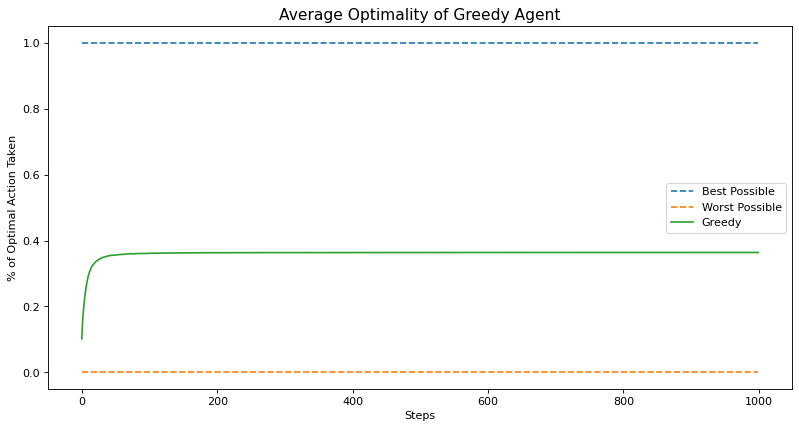

In [110]:
%matplotlib inline
num_experiments = 10000
num_steps = 1000
num_actions = 10

# Initialize the environment
env = ArmedBanditsGaussian(num_experiments, num_actions)
# Initialize the agent
agent = GreedyAgent(np.zeros((num_experiments, num_actions)))

# Store the scores and averages for later plotting
averages = np.zeros((num_steps))
optimality = np.zeros((num_steps))
scores = np.zeros((num_experiments, num_steps+1))

#Store the optimal actions for later use
optimal = np.argmax(env.mean, axis=1)

for i in tqdm(range(num_steps)):
    # Select an action to execute on the environment
    action = agent.get_action()
    # print(action)
    # print(action.shape)
    _, reward, _, _ = env.step(action)
    
    # Update the agent estimates with the previously observed rewards
    agent.update_estimates(reward, action)
    
    # Store the average cumulative score and optimality of the current step
    scores[:,i+1] = scores[:,i] + reward
    avg_score = np.mean(scores[:,i+1]/(i+1))
    averages[i] = avg_score
    
    # Get optimal actions from the environment
    current_optimality = np.mean(action == optimal)
    optimality[i] = current_optimality
    
plt.figure(figsize=(12,6), dpi=80, facecolor='w', edgecolor='k')
plt.plot([1.0 for _ in range(num_steps)], linestyle='--')
plt.plot([0.0 for _ in range(num_steps)], linestyle='--')
plt.plot(optimality)
plt.legend(["Best Possible", "Worst Possible", "Greedy"])
plt.title("Average Optimality of Greedy Agent", fontsize=14)
plt.ylabel("% of Optimal Action Taken")
plt.xlabel("Steps")
plt.show()
greedy_scores = averages
greedy_optimality = optimality

The Greedy Agent chooses the best action on average ~40% of the times. Additionally, extra experience won't improve it's score, as it usually lands on a sub-optimal action on the first steps, and stays there for ever. The Greedy Agent is not a good strategy for finding the optimal action on this scenario.

## The Epsilon-Greedy Agent

Another strategy is the Epsilon Greedy Agent, which adds to the previous strategy. An Epsilon-Greedy Agent allows for some exploratory actions, by every once in a while choosing any action randomly, instead of always acting greedily. The probability of taking an exploratory action is defined by the parameter `epsilon`. An epsilon of `0` is a Greedy Agent. An epsilon of `0.2` means our agent takes a random action 20% of the time. An epsilon of `1` is an agent that behaves randomly. Let's build this new agent

In [111]:
class EpsilonGreedyAgent(GreedyAgent):
    def __init__(self, reward_estimates, epsilon):
        GreedyAgent.__init__(self, reward_estimates)
        # Store the epsilon value
        assert epsilon >= 0 and epsilon <= 1
        self.epsilon = epsilon
    
    def get_action(self):
        # We need to redefine this function so that it takes an exploratory action with epsilon probability
        
        # One hot encoding: 0 if exploratory, 1 otherwise
        action_type = (np.random.random_sample(self.num_experiments) > self.epsilon).astype(int)
        # Generate both types of actions for every experiment
        exploratory_action = np.random.randint(self.num_bandits, size=self.num_experiments)
        greedy_action = argmax(self.reward_estimates)
        # Use the one hot encoding to mask the actions for each experiment
        action = greedy_action * action_type + exploratory_action * (1 - action_type)
        
        self.action_count[np.arange(self.num_experiments), action] += 1
        
        return action

As may be seen, we're inheriting the `GreedyAgent` implementation, and only changing the `get_action` function. For taking an action, we're using a masking that defines which experiments will choose an action randomly and which will act greedily. Then, we apply that masking between random and greedy actions to obtain the action vector for all of our experiments.

### Testing the Agent

Here, we're going to use the same animation as before to observe how this new strategy behaves. Our agents will have a value of epsilon of `0.1`

In [112]:
# Initialize the environment of our multi-armed bandit problem
%matplotlib notebook
num_experiments = 2
num_bandits = 8
num_steps = 200
means = np.random.normal(size=(num_experiments, num_bandits))
stdev = np.ones((num_experiments, num_bandits))

env = ArmedBanditsEnv(means, stdev)

# Initialize the agent
agent = EpsilonGreedyAgent(np.zeros((num_experiments,num_bandits)), 0.1)

# Code for plotting the interaction
fig, axs = plt.subplots(1, num_experiments, figsize=(10, 4))
x_pos = np.arange(num_bandits)

def init():
    for i in range(num_experiments):
        init_ax(i)
        
    
def init_ax(i):
    ax = axs[i]
    ax.clear()
    ax.set_ylim(-4, 4)
    ax.set_xlim(-0.5, num_bandits-.5)
    ax.set_xlabel('Actions', fontsize=14)
    ax.set_ylabel('Value', fontsize=14)
    ax.set_title(label='Estimated Values vs. Real values', fontsize=15)
    ax.plot(x_pos, env.mean[i], marker='D', linestyle='', alpha=0.8, color='r', label='Real Values')
    ax.axhline(0, color='black', lw=1)
    
# Implement a step, which involves the agent acting upon the
# environment and learning from the received reward.
def step(g):
    action = agent.get_action()
    _, reward, _, _ = env.step(action)
    agent.update_estimates(reward, action)
    for i in range(num_experiments):
        ax = axs[i]
        # Plot the estimated values from the agent compared to the real values
        estimates = agent.reward_estimates[i]
        init_ax(i)
        values = ax.bar(x_pos, estimates, align='center', color='blue', alpha=0.4, label='Estimated Values')
        ax.legend()
    
anim = FuncAnimation(fig, func=step, frames=np.arange(num_steps), init_func=init, interval=10, repeat=False, blit=True)
plt.show()

# Uncomment the next line if you wish to store the animations as a gif
anim.save('./epsilon-greedy-agent.gif', writer='pillow', fps=60)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/matplotlib/cbook/__init__.py", line 196, in process
    func(*args, **kwargs)
  File "/usr/local/lib/python3.8/dist-packages/matplotlib/animation.py", line 1467, in _stop
    self.event_source.remove_callback(self._loop_delay)
AttributeError: 'NoneType' object has no attribute 'remove_callback'


Again, you may run the previous block multiple times to see different runs. As can be observed, the epsilon-greedy agent not only finds the optimal solution most of the times, but it is also capable of finding close estimated values for all the actions! Observe how the new strategy compares to the greedy agent on average.

In [113]:
def run_experiment(num_experiments=1000, num_steps=1000, num_actions=10,epsilon=0.1):
    # Initialize the environment
    env = ArmedBanditsGaussian(num_experiments, num_actions)
    # Initialize the agent
    agent = EpsilonGreedyAgent(np.zeros((num_experiments, num_actions)), epsilon)
    
    # Store the scores and averages for later plotting
    averages = np.zeros((num_steps))
    optimality = np.zeros((num_steps))
    scores = np.zeros((num_experiments, num_steps+1))
    
    #Store the optimal actions for later use
    optimal = np.argmax(env.mean, axis=1)
    
    for i in tqdm(range(num_steps)):
        # Select an action to execute on the environment
        action = agent.get_action()
        _, reward, _, _ = env.step(action)
        
        # Update the agent estimates with the previously observed rewards
        agent.update_estimates(reward, action)
        
        # Store the average cumulative score and optimality of the current step
        scores[:,i+1] = scores[:,i] + reward
        avg_score = np.mean(scores[:,i+1]/(i+1))
        averages[i] = avg_score
        
        # Get optimal actions from the environment
        current_optimality = np.mean(action == optimal)
        optimality[i] = current_optimality
    return optimality, averages

100%|██████████| 1000/1000 [00:06<00:00, 161.43it/s]


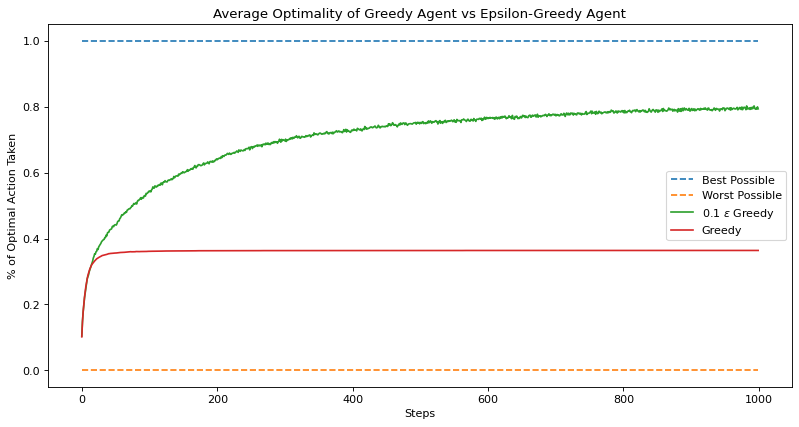

In [114]:
%matplotlib inline
num_experiments = 10000
num_steps = 1000
num_actions = 10
epsilon = 0.1

balanced_eps_optimality, balanced_eps_scores = run_experiment(num_experiments, num_steps, num_actions, epsilon)

plt.figure(figsize=(12,6), dpi=80, facecolor='w', edgecolor='k')
plt.plot([1.0 for _ in range(num_steps)], linestyle='--')
plt.plot([0.0 for _ in range(num_steps)], linestyle='--')
plt.plot(balanced_eps_optimality)
plt.plot(greedy_optimality)
plt.legend(["Best Possible", "Worst Possible", "0.1 $\epsilon$ Greedy", "Greedy"])
plt.title("Average Optimality of Greedy Agent vs Epsilon-Greedy Agent")
plt.ylabel("% of Optimal Action Taken")
plt.xlabel("Steps")
plt.show()

After 1000 steps, the Epsilon-Greedy Agent is capable of reaching an 80% average optimality. This means that on average, they choose the best possible action 80% of the times after that amount of iterations. We can also see how our agent is capable of improving from experience, contrary to the Greedy Agent.

## Values for epsilon

On the previous example, we used a value for `epsilon` of `0.1`. This means that the agent chose an exploratory action 10% of the times. Like with almost all hyper-parameters in Machine Learning, there's a range of values which behave better than others. Let's make an actual experiment using different values for `epsilon`

100%|██████████| 1000/1000 [00:00<00:00, 1554.74it/s]


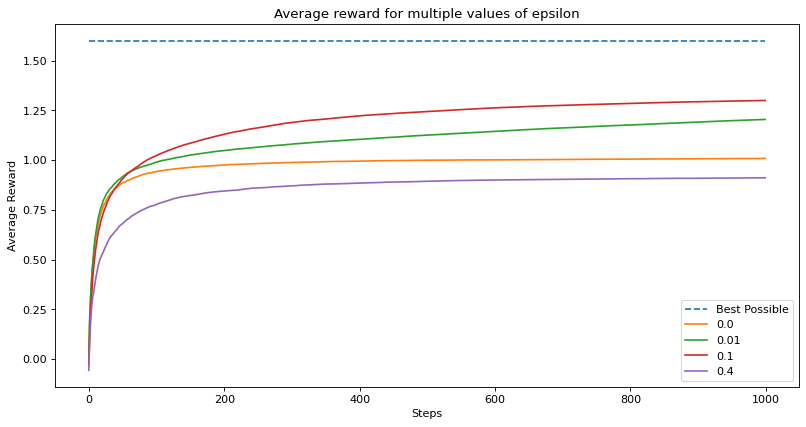

In [115]:
%matplotlib inline
num_experiments = 1000
num_steps = 1000
num_actions = 10
epsilons = np.array([0.0, 0.01, 0.1, 0.4])

plt.figure(figsize=(12,6), dpi=80, facecolor='w', edgecolor='k')
plt.plot([1.6 for _ in range(num_steps)], linestyle='--') # why 1.6?


for epsilon in epsilons:
    _, reward = run_experiment(num_experiments, num_steps, num_actions, epsilon)
    
    plt.plot(reward)
    
plt.legend(["Best Possible"] + epsilons.tolist())
plt.title("Average reward for multiple values of epsilon")
plt.xlabel("Steps")
plt.ylabel("Average Reward")
plt.show()

Here, we're plotting the average amount of reward received by the agent. This is because plotting the optimality on this many tests gets too crowded and noisy. As can be seen, the agent with an epsilon of `0.1` was the one that received the most amount of reward. Values of epsilon that are too small take very few exploratory actions, and therefore take a long time to explore and find the most optimal value. On the other hand, values of `epsilon` too high will obstruct the capacity of the agent of acting optimally. Too much exploration gets in the way of exploitation.

## Note

The GIF's will not be displayed on colab but will be saved aside.

***
# Assignment questions

Now that we have familiarized ourselves with the basic setup let us test a few more stratergies and see how they compare to the greedy and the epsilon greedy agent stratergies. 

## Part 1: Time Varying $\epsilon$-Greedy Algorithm

Create an agent that implements the Time Verying $\epsilon$-Greedy strategy. Implement using two parameters, one for the starting value of $\epsilon=\epsilon_0$ and other for the decay rate linear/exponential. Starting with the value of $\epsilon_0=1$ for epsilon and decay it linearly/exponentially to a very small value. The type of decay and the starting value of epsilon are input parameters to the function, include these in the function definition.

linear rate $\epsilon = \epsilon_0(1-t/T)$ <br />
exponential rate $\epsilon = \epsilon_0t^{-1/3}$

### 1.1 Time Varying $\epsilon$-Greedy Agent 

For this part realize an agent class that executes the Time Varying $\epsilon$-Greedy Algorithm. `[5 Marks]`

In [116]:
# Desired Agent class implementation
class TimeVaryingGreedyAgent(EpsilonGreedyAgent):
    def __init__(self, reward_estimates, epsilon, decay):
        EpsilonGreedyAgent.__init__(self, reward_estimates,epsilon)
        self.decay = decay #exponential or linear
    
    def get_action(self, time_step, num_steps):
        # We need to redefine this function so that it takes an exploratory action with epsilon probability
        if(self.decay == "linear"):
            epsilon = self.epsilon - time_step/num_steps
        elif(self.decay == "exponential"):
            if(int(time_step) == 0): #instead of doing(1+1)**(-1/3), I have used if condition 
                epsilon = self.epsilon
            else:
                epsilon = self.epsilon*(time_step)**(-1/3)
        # One hot encoding: 0 if exploratory, 1 otherwise
        action_type = (np.random.random_sample(self.num_experiments) > epsilon).astype(int)
        # Generate both types of actions for every experiment
        exploratory_action = np.random.randint(self.num_bandits, size=self.num_experiments)
        greedy_action = argmax(self.reward_estimates)
        # Use the one hot encoding to mask the actions for each experiment
        action = greedy_action * action_type + exploratory_action * (1 - action_type)
        
        self.action_count[np.arange(self.num_experiments), action] += 1
        
        return action

### 1.2 Testing the agent

Observe how this Time varying $\epsilon$-greedy Agent behaves on the environment for linear decay case with $\epsilon_0 = 1$. For this, try to generate some animations as before to see how the agent estimates the values for each action, as well as the real values provided by the environment. Remember that the agent doesn't have access to that information. Write your code below `[2 Marks]`

In [117]:
# Write your code for testing the Time varying epsilon greedy agent
# Initialize the environment of our multi-armed bandit problem
%matplotlib notebook
num_experiments = 2
num_bandits = 8
num_steps = 100
means = np.random.normal(size=(num_experiments, num_bandits))
stdev = np.ones((num_experiments, num_bandits))

env = ArmedBanditsEnv(means, stdev)

# Initialize the agent
agent = TimeVaryingGreedyAgent(np.zeros((num_experiments,num_bandits)),1,"linear")

# Code for plotting the interaction
fig, axs = plt.subplots(1, num_experiments, figsize=(10, 4))
x_pos = np.arange(num_bandits)

def init():
    for i in range(num_experiments):
        init_ax(i)
        
def init_ax(i):
    ax = axs[i]
    ax.clear()
    ax.set_ylim(-4, 4)
    ax.set_xlim(-0.5, num_bandits-.5)
    ax.set_xlabel('Actions', fontsize=14)
    ax.set_ylabel('Value', fontsize=14)
    ax.set_title(label='Estimated Values vs. Real values', fontsize=15)
    ax.plot(x_pos, env.mean[i], marker='D', linestyle='', alpha=0.8, color='r', label='Real Values')
    ax.axhline(0, color='black', lw=1)

# Implement a step, which involves the agent acting upon the
# environment and learning from the received reward.
def step(g):
    action = agent.get_action(g,num_steps)
    _, reward, _, _ = env.step(action)
    agent.update_estimates(reward, action)
    for i in range(num_experiments):
        ax = axs[i]
        # Plot the estimated values from the agent compared to the real values
        estimates = agent.reward_estimates[i]
        init_ax(i)
        values = ax.bar(x_pos, estimates, align='center', color='blue', alpha=0.4, label='Estimated Values')
        ax.legend()
    
anim = FuncAnimation(fig, func=step, frames=num_steps, init_func=init, interval=10, repeat=False, blit=True)
plt.show()

# Uncomment the next line if you wish to store the animations as a gif
anim.save('./timevarying_greedy-agent.gif', writer='pillow', fps=60)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/matplotlib/cbook/__init__.py", line 196, in process
    func(*args, **kwargs)
  File "/usr/local/lib/python3.8/dist-packages/matplotlib/animation.py", line 1467, in _stop
    self.event_source.remove_callback(self._loop_delay)
AttributeError: 'NoneType' object has no attribute 'remove_callback'


### 1.3 Experimenting with parameters

Design and test using an experiment using different values for $\epsilon_0 \in$ `{0 0.01 0.1 0.5 1}` along with linear and exponential decay scheme similar to what we earlier did. Write your code below for the experiment and plot the average reward and the average optimality ratio for various values of $\epsilon$ and decay scheme. What combination of $\epsilon$ and decay scheme generates the maximum average reward over 1000 steps? What value of $\epsilon_0$ and decay scheme leads to highest average optimality? Is your answer to the above two parts same? `[3 Marks]`

In [119]:
# Write your code for the experiment to test different values of parameters for Time varying epsilon-greedy agent
def run_experiment_time_varying(num_experiments=1000, num_steps=1000, num_actions=10,epsilon=0.1,decay="exponential"):
    # Initialize the environment
    env = ArmedBanditsGaussian(num_experiments, num_actions)
    # Initialize the agent
    agent = TimeVaryingGreedyAgent(np.zeros((num_experiments, num_actions)), epsilon, decay)
    
    # Store the scores and averages for later plotting
    averages = np.zeros((num_steps))
    optimality = np.zeros((num_steps))
    scores = np.zeros((num_experiments, num_steps+1))
    
    #Store the optimal actions for later use
    optimal = np.argmax(env.mean, axis=1)
    
    for i in tqdm(range(num_steps)):
        # Select an action to execute on the environment
        action = agent.get_action(i,num_steps)
        _, reward, _, _ = env.step(action)
        
        # Update the agent estimates with the previously observed rewards
        agent.update_estimates(reward, action)
        
        # Store the average cumulative score and optimality of the current step
        scores[:,i+1] = scores[:,i] + reward
        avg_score = np.mean(scores[:,i+1]/(i+1))
        averages[i] = avg_score
        
        # Get optimal actions from the environment
        current_optimality = np.mean(action == optimal)
        optimality[i] = current_optimality
    return optimality, averages

100%|██████████| 1000/1000 [00:05<00:00, 178.71it/s]


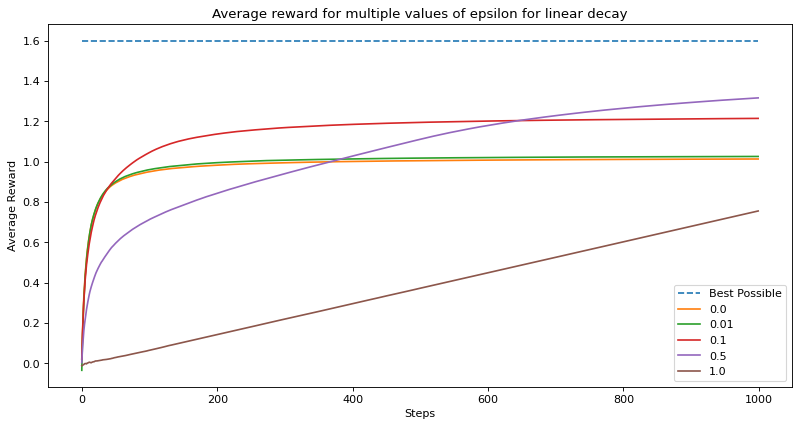

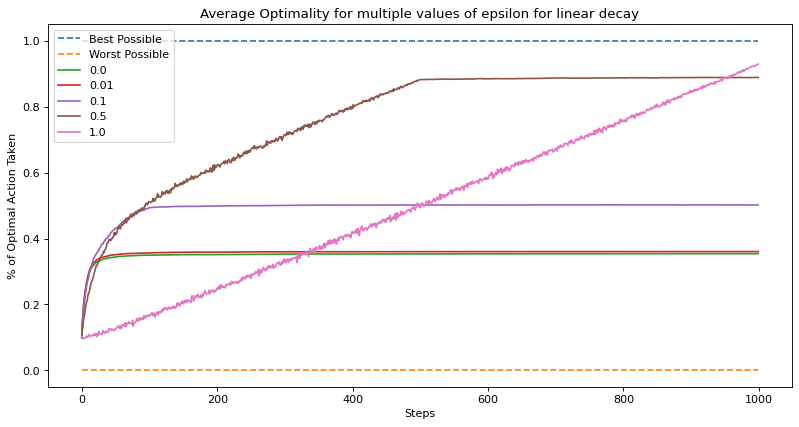

100%|██████████| 1000/1000 [00:06<00:00, 154.89it/s]


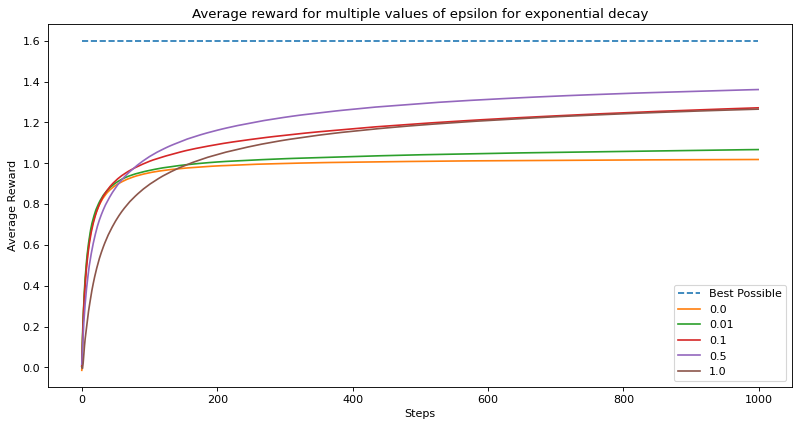

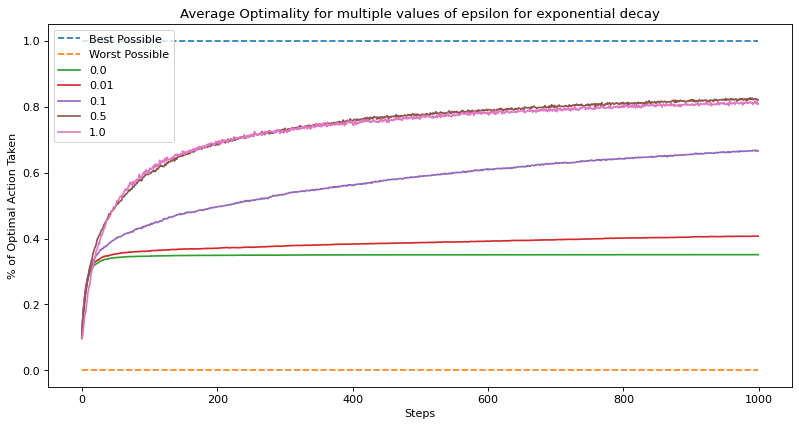

In [124]:
%matplotlib inline
num_experiments = 10000
num_steps = 1000
num_actions = 10
epsilons = np.array([0.0, 0.01, 0.1, 0.5, 1.0])

plt.figure(figsize=(12,6), dpi=80, facecolor='w', edgecolor='k')
plt.plot([1.6 for _ in range(num_steps)], linestyle='--')
optimal = []
rewards =[]

#Linear Decay
for epsilon in epsilons:
    optimality, reward = run_experiment_time_varying(num_experiments, num_steps, num_actions, epsilon,"linear")
    optimal.append(optimality)
    rewards.append(reward) 

for _,reward in enumerate(rewards):
    plt.plot(reward)
    
plt.legend(["Best Possible"] + epsilons.tolist())
plt.title("Average reward for multiple values of epsilon for linear decay")
plt.xlabel("Steps")
plt.ylabel("Average Reward")
plt.show()

plt.figure(figsize=(12,6), dpi=80, facecolor='w', edgecolor='k')
plt.plot([1.0 for _ in range(num_steps)], linestyle='--')
plt.plot([0.0 for _ in range(num_steps)], linestyle='--')

for _,optimality in enumerate(optimal):
    plt.plot(optimality)

plt.legend(["Best Possible", "Worst Possible"] + epsilons.tolist())
plt.title("Average Optimality for multiple values of epsilon for linear decay")
plt.ylabel("% of Optimal Action Taken")
plt.xlabel("Steps")
plt.show()


plt.figure(figsize=(12,6), dpi=80, facecolor='w', edgecolor='k')
plt.plot([1.6 for _ in range(num_steps)], linestyle='--')
optimal = []
rewards =[]

#Exponential decay
for epsilon in epsilons:
    optimality, reward = run_experiment_time_varying(num_experiments, num_steps, num_actions, epsilon,"exponential")
    optimal.append(optimality) 
    rewards.append(reward)

for _,reward in enumerate(rewards):
    plt.plot(reward)
    
plt.legend(["Best Possible"] + epsilons.tolist())
plt.title("Average reward for multiple values of epsilon for exponential decay")
plt.xlabel("Steps")
plt.ylabel("Average Reward")
plt.show()

plt.figure(figsize=(12,6), dpi=80, facecolor='w', edgecolor='k')
plt.plot([1.0 for _ in range(num_steps)], linestyle='--')
plt.plot([0.0 for _ in range(num_steps)], linestyle='--')

for _,optimality in enumerate(optimal):
    plt.plot(optimality)

plt.legend(["Best Possible", "Worst Possible"] + epsilons.tolist())
plt.title("Average Optimality for multiple values of epsilon for exponential decay")
plt.ylabel("% of Optimal Action Taken")
plt.xlabel("Steps")
plt.show()

1.3 Looking at the graphs of average rewards and average optimality, the highest average reward is for epsilon value of 0.5 and decay scheme "exponential" and the highest average optimality is for epsilon value of 1 and decay scheme "linear". No, the answer is not the same. 

## Part 2: Successive Elimination Algorithm (SEA)

Create an agent that solves the given MAB problem using the successive elimination algorithm. The algorithm adaptively eliminates arms that are detected to be worse that other arms with high probability using the deactivation rule. Realize your agent using the weight parameter `c` for the uncertainity term.

### 2.1 SEA Agent

For this part realize an agent class that executes the Successive Elimination Algorithm as discussed in the class. For this part you may need to use the weight parameter `c` for the uncertainity term.In the class we have used $c = \sqrt{2}$, here we experiment with other values of parameter $c$  

$LCB_t(a) = \mu_t - c \cdot \sqrt{\frac{\log T}{n_t(a)}}$, $UCB_t(a) = \mu_t + c \cdot \sqrt{\frac{\log T}{n_t(a)}}$

`[5 Marks]`

In [121]:
# SEA Agent implementation
class SEA(GreedyAgent):
    def __init__(self, reward_estimates, active_arms, c):
        GreedyAgent.__init__(self, reward_estimates)
        self.c = c
        self.active_arms = active_arms
    
    def ucb(self,num_steps):
        return self.reward_estimates + self.c*(np.sqrt(np.log(num_steps)/self.action_count))
    
    def lcb(self,num_steps):
        return self.reward_estimates - self.c*(np.sqrt(np.log(num_steps)/self.action_count))

    def get_action(self):
        self.action_count[self.active_arms] += 1
        return self.active_arms

    def update_estimates(self,reward,num_steps):
        n = self.action_count[self.active_arms]
        prev_reward_estimates = self.reward_estimates[self.active_arms]
        # Update the reward estimates incementally
        self.reward_estimates[self.active_arms] = inc_avg(prev_reward_estimates,reward,n)
        LCB = self.lcb(num_steps)
        UCB = self.ucb(num_steps)
        LCB_max = np.array([LCB[i, self.active_arms[i]].max() for i in range(self.num_experiments)])
        LCB_max = LCB_max.reshape((self.num_experiments,1))
        LCB_max = np.tile(LCB_max,(1,self.num_bandits))
        active = UCB >= LCB_max
        self.active_arms = self.active_arms * active

### 2.2 Testing the Agent

Observe how this SEA Agent behaves on the environment for a fixed value of parameter `c = 1`. For this, try to generate some animations as before to see how the agent estimates the values for each action, as well as the real values provided by the environment. For this part try and plot the confidence interval for the reward estimate of each arm rather than just the point estimates. Write your code below `[2 Marks]`

In [123]:
# Write your code for testing the Time varying epsilon greedy agent
# Initialize the environment of our multi-armed bandit problem
%matplotlib notebook
num_experiments = 2
num_bandits = 8
num_steps = 100
means = np.random.normal(size=(num_experiments, num_bandits))
stdev = np.ones((num_experiments, num_bandits))

env = ArmedBanditsEnv(means, stdev)

# Initialize the agent
active_arms = np.full((num_experiments,num_bandits),True,dtype =bool)
agent = SEA(np.zeros((num_experiments,num_bandits)),active_arms,1)

# Code for plotting the interaction
fig, axs = plt.subplots(1, num_experiments, figsize=(10, 4))
x_pos = np.arange(num_bandits)

def init():
    for i in range(num_experiments):
        init_ax(i)
        
def init_ax(i):
    ax = axs[i]
    ax.clear()
    ax.set_ylim(-4, 4)
    ax.set_xlim(-0.5, num_bandits-.5)
    ax.set_xlabel('Actions', fontsize=14)
    ax.set_ylabel('Value', fontsize=14)
    ax.set_title(label='Estimated Values vs. Real values', fontsize=15)
    ax.plot(x_pos, env.mean[i], marker='D', linestyle='', alpha=0.8, color='r', label='Real Values')
    ax.axhline(0, color='black', lw=1)

# Implement a step, which involves the agent acting upon the
# environment and learning from the received reward.
def step(g):
    action = agent.get_action()
    _, reward, _, _ = env.step(action)
    agent.update_estimates(reward,num_steps)
    for i in range(num_experiments):
        ax = axs[i]
        # Plot the estimated values from the agent compared to the real values
        estimates = agent.reward_estimates[i]
        init_ax(i)
        values = ax.bar(x_pos, estimates, align='center', color='blue', alpha=0.4, label='Estimated Values')
        ax.legend()
    
anim = FuncAnimation(fig, func=step, frames=num_steps, init_func=init, interval=10, repeat=False, blit=True)
plt.show()

# Uncomment the next line if you wish to store the animations as a gif
anim.save('./SEA_agent.gif', writer='pillow', fps=60)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/matplotlib/cbook/__init__.py", line 196, in process
    func(*args, **kwargs)
  File "/usr/local/lib/python3.8/dist-packages/matplotlib/animation.py", line 1467, in _stop
    self.event_source.remove_callback(self._loop_delay)
AttributeError: 'NoneType' object has no attribute 'remove_callback'


### 2.3 Values for weight parameter `c`

Design and test using an experiment using different values for `c` in `{0 1 2 3 4}` similar to what we earlier did. Write your code below for the experiment and plot the average reward and the average optimality ratio for various values of `c`. What value of `c` generates the maximum average reward over 1000 steps? What value of `c` leads to highest average optimality? Is your answer to the above two parts same? `[3 Marks]`

In [125]:
# Write your code for the experiment to test different values of weight parameters
%matplotlib inline
def run_experiment_sea(num_experiments=1000, num_steps=1000, num_actions=10,c=1):
    # Initialize the environment
    env = ArmedBanditsGaussian(num_experiments, num_actions)
    # Initialize the agent

    active_arms = np.full((num_experiments,num_actions),True,dtype =bool)
    agent = SEA(np.zeros((num_experiments,num_actions)),active_arms,c)
    
    # Store the scores and averages for later plotting
    averages = np.zeros((num_steps))
    optimality = np.zeros((num_steps))
    scores = np.zeros((num_experiments, num_steps+1))
    
    #Store the optimal actions for later use
    optimal = np.argmax(env.mean, axis=1)
    score = 0
    r_count = 0
    for i in tqdm(range(num_steps)):
    # Select an action to execute on the environment
        action = agent.get_action()
        _, reward, _, _ = env.step(action)

        agent.update_estimates(reward, num_steps)

        # Store the average cumulative score and optimality of the current step
        score += np.sum(reward)
        r_count += reward.shape[0]
        averages[i] = score/r_count
        
        # Get optimal actions from the environment
        current_optimality = np.sum(agent.active_arms[np.arange(agent.num_experiments),optimal]==True) / len(reward)
        optimality[i] = current_optimality
    return optimality, averages

100%|██████████| 1000/1000 [01:09<00:00, 14.48it/s]


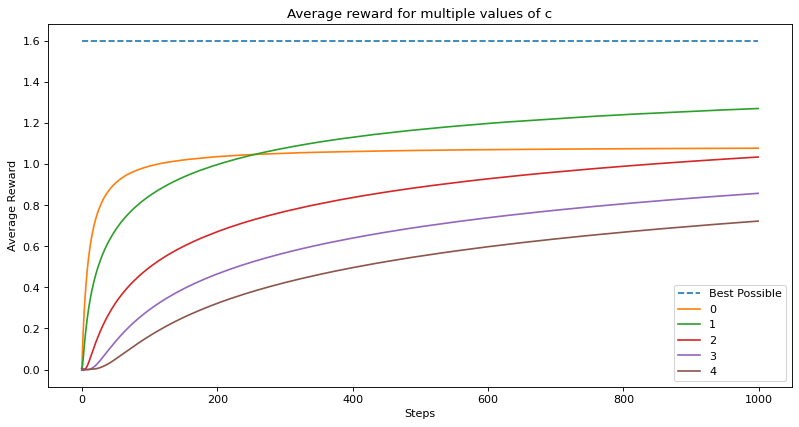

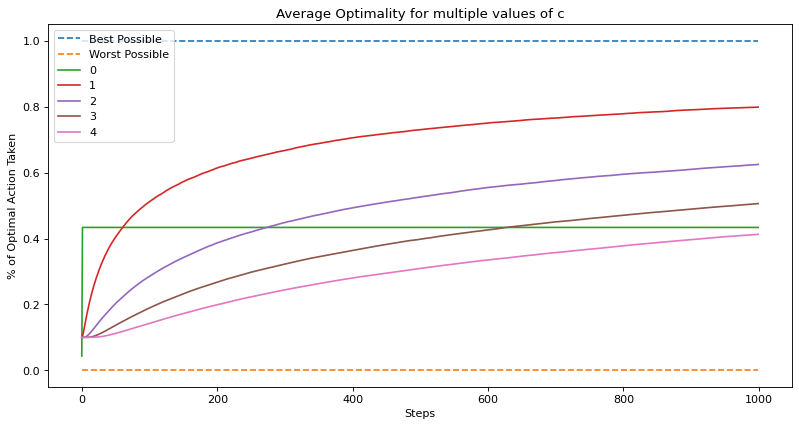

In [126]:
# Write your code for the experiment to test different values of weight parameters
%matplotlib inline
num_experiments = 10000
num_steps = 1000
num_actions = 10
c_s = np.array([0, 1, 2, 3, 4])

plt.figure(figsize=(12,6), dpi=80, facecolor='w', edgecolor='k')
plt.plot([1.6 for _ in range(num_steps)], linestyle='--')
optimal = []
rewards = []

for c in c_s:
    optimality, reward = run_experiment_sea(num_experiments, num_steps, num_actions, c)
    optimal.append(optimality)
    rewards.append(reward) 

for _,reward in enumerate(rewards):
    plt.plot(reward)

plt.legend(["Best Possible"] + c_s.tolist())
plt.title("Average reward for multiple values of c")
plt.xlabel("Steps")
plt.ylabel("Average Reward")
plt.show()

plt.figure(figsize=(12,6), dpi=80, facecolor='w', edgecolor='k')
plt.plot([1.0 for _ in range(num_steps)], linestyle='--')
plt.plot([0.0 for _ in range(num_steps)], linestyle='--')

for _,optimality in enumerate(optimal):
    plt.plot(optimality)

plt.legend(["Best Possible", "Worst Possible"] + c_s.tolist())
plt.title("Average Optimality for multiple values of c")
plt.ylabel("% of Optimal Action Taken")
plt.xlabel("Steps")
plt.show()

Value of c=1 produces the maximum average reward and the highest average optimality. Yes, the answers to both are same 

## Part 3: The Upper-Confidence-Bound (UCB) Algorithm

The greedy actions are those that look best at present, but some of the other actions may actually be better. epsilon-greedy action selection forces the non-greedy actions to be tried, but indiscriminately, with no preference for those that are nearly greedy or particularly uncertain. It would be better to select among the non-greedy actions according to their potential for actually being optimal, taking into account both how close their estimates are to being maximal and the uncertainties in those estimates. 

### 3.1 UCB Agent

For this part realize an agent class that executes the UCB Algorithm as discussed in the class. For this part you may need to use the weight parameter $c$ for the uncertainity term. In the class we have used $c = \sqrt{2}$, here we experiment with other values of parameter $c$  

$UCB_t = \mu_t + c \cdot \sqrt{\frac{\log T}{n_t(a)}}$

`[5 Marks]`

In [127]:
# UCB Agent implementation
class ucbagent(GreedyAgent):
    def __init__(self,reward_estimates, c):
        GreedyAgent.__init__(self, reward_estimates)
        self.c = c
    
    def ucb(self,num_steps):
        return self.reward_estimates + self.c*(np.sqrt(np.log(num_steps)/self.action_count))
    
    def do_all_actions(self,i):
        action = np.zeros((self.num_experiments,))
        action.fill(i) #doing each action for all experiments
        self.action_count[np.arange(self.num_experiments), action.astype(int)] += 1
        return action.astype(int)

    def get_action(self, num_steps):
        action = argmax(self.ucb(num_steps))
        self.action_count[np.arange(self.num_experiments),action] += 1
        return action

### 3.2 Testing the agent

Observe how this UCB Agent behaves on the environment for a fixed value of parameter `c = 1`. For this, try to generate some animations as before to see how the agent estimates the values for each action, as well as the real values provided by the environment. Remember that the agent doesn't have access to that information. For this part try and plot the confidence interval for the reward estimate of each arm rather than just the point estimates. Write your code below `[2 Marks]`

In [128]:
# Write your code for testing the UCB agent
# Initialize the environment of our multi-armed bandit problem
%matplotlib notebook
num_experiments = 2
num_bandits = 8
num_steps = 100
means = np.random.normal(size=(num_experiments, num_bandits))
stdev = np.ones((num_experiments, num_bandits))

env = ArmedBanditsEnv(means, stdev)

# Initialize the agent
agent = ucbagent(np.zeros((num_experiments,num_bandits)),1)

# Code for plotting the interaction
fig, axs = plt.subplots(1, num_experiments, figsize=(10, 4))
x_pos = np.arange(num_bandits)

def init():
    for i in range(num_experiments):
        init_ax(i)
        
def init_ax(i):
    ax = axs[i]
    ax.clear()
    ax.set_ylim(-4, 4)
    ax.set_xlim(-0.5, num_bandits-.5)
    ax.set_xlabel('Actions', fontsize=14)
    ax.set_ylabel('Value', fontsize=14)
    ax.set_title(label='Estimated Values vs. Real values', fontsize=15)
    ax.plot(x_pos, env.mean[i], marker='D', linestyle='', alpha=0.8, color='r', label='Real Values')
    ax.axhline(0, color='black', lw=1)

#Executing each action once according to the UCB algorithm
for i in range(num_bandits):
    action = agent.do_all_actions(i)
    _, reward, _, _ = env.step(action)
    agent.update_estimates(reward, action)

# Implement a step, which involves the agent acting upon the
# environment and learning from the received reward.
def step(g):
    action = agent.get_action(num_steps)
    _, reward, _, _ = env.step(action)
    agent.update_estimates(reward, action)
    for i in range(num_experiments):
        ax = axs[i]
        # Plot the estimated values from the agent compared to the real values
        estimates = agent.reward_estimates[i]
        init_ax(i)
        values = ax.bar(x_pos, estimates, align='center', color='blue', alpha=0.4, label='Estimated Values')
        ax.legend()
    
anim = FuncAnimation(fig, func=step, frames=num_steps, init_func=init, interval=10, repeat=False, blit=True)
plt.show()

# Uncomment the next line if you wish to store the animations as a gif
anim.save('./ucb-agent.gif', writer='pillow', fps=60)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/matplotlib/cbook/__init__.py", line 196, in process
    func(*args, **kwargs)
  File "/usr/local/lib/python3.8/dist-packages/matplotlib/animation.py", line 1467, in _stop
    self.event_source.remove_callback(self._loop_delay)
AttributeError: 'NoneType' object has no attribute 'remove_callback'


### 3.3 Values for weight parameter `c`

Design and test using an experiment using different values for `c` in `{0 1 2 3 4}` similar to what we earlier did. Write your code below for the experiment and plot the average reward and the average optimality ratio for various values of `c`. What value of `c` generates the maximum average reward over 1000 steps? What value of `c` leads to highest average optimality? Is your answer to the above two parts same? `[3 Marks]`

In [129]:
# Write your code for the experiment to test different values of parameters for UCB agent
def run_experiment_ucb(num_experiments=1000, num_steps=1000, num_actions=10,c=1):
    # Initialize the environment
    env = ArmedBanditsGaussian(num_experiments, num_actions)
    # Initialize the agent
    agent = ucbagent(np.zeros((num_experiments, num_actions)), c)
    
    # Store the scores and averages for later plotting
    averages = np.zeros((num_steps))
    optimality = np.zeros((num_steps))
    scores = np.zeros((num_experiments, num_steps+1))
    
    #Store the optimal actions for later use
    optimal = np.argmax(env.mean, axis=1)
    
    for i in range(num_actions):
        action = agent.do_all_actions(i)
        _, reward, _, _ = env.step(action)
        agent.update_estimates(reward, action)

    for i in tqdm(range(num_steps)):
        # Select an action to execute on the environment
        action = agent.get_action(num_steps)
        _, reward, _, _ = env.step(action)
        
        # Update the agent estimates with the previously observed rewards
        agent.update_estimates(reward, action)
        
        # Store the average cumulative score and optimality of the current step
        scores[:,i+1] = scores[:,i] + reward
        avg_score = np.mean(scores[:,i+1]/(i+1))
        averages[i] = avg_score
        
        # Get optimal actions from the environment
        current_optimality = np.mean(action == optimal)
        optimality[i] = current_optimality
    return optimality, averages

100%|██████████| 1000/1000 [00:05<00:00, 172.64it/s]


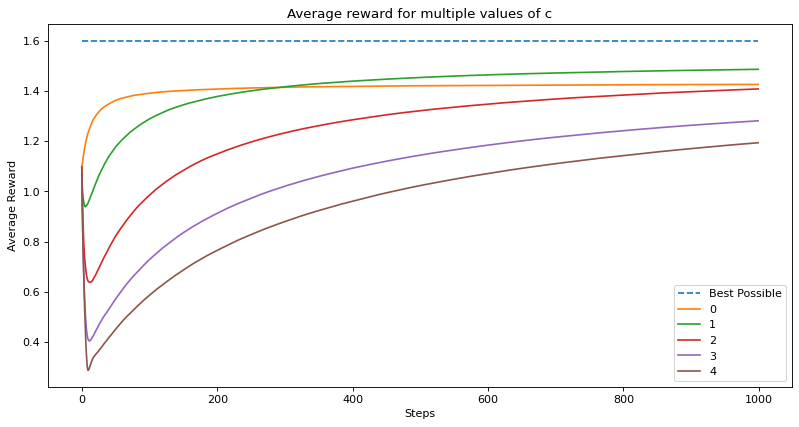

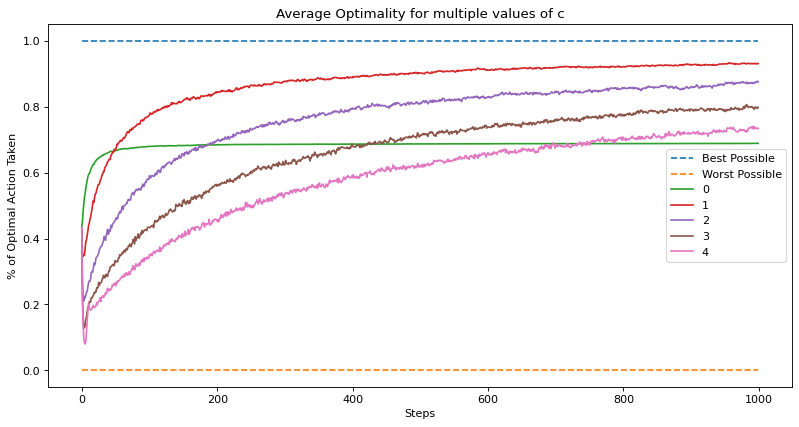

In [130]:
# Write your code for the experiment to test different values of weight parameters
%matplotlib inline
num_experiments = 10000
num_steps = 1000
num_actions = 10
c_s = np.array([0, 1, 2, 3, 4])

plt.figure(figsize=(12,6), dpi=80, facecolor='w', edgecolor='k')
plt.plot([1.6 for _ in range(num_steps)], linestyle='--')
optimal = []
rewards = []

for c in c_s:
    optimality, reward = run_experiment_ucb(num_experiments, num_steps, num_actions, c)
    optimal.append(optimality)
    rewards.append(reward) 

for _,reward in enumerate(rewards):
    plt.plot(reward)

plt.legend(["Best Possible"] + c_s.tolist())
plt.title("Average reward for multiple values of c")
plt.xlabel("Steps")
plt.ylabel("Average Reward")
plt.show()

plt.figure(figsize=(12,6), dpi=80, facecolor='w', edgecolor='k')
plt.plot([1.0 for _ in range(num_steps)], linestyle='--')
plt.plot([0.0 for _ in range(num_steps)], linestyle='--')

for _,optimality in enumerate(optimal):
    plt.plot(optimality)

plt.legend(["Best Possible", "Worst Possible"] + c_s.tolist())
plt.title("Average Optimality for multiple values of c")
plt.ylabel("% of Optimal Action Taken")
plt.xlabel("Steps")
plt.show()

3.3 Value of c =1 leads to the highest average reward and average optimality for 1000 time steps. Yes, the answers are same.

## Part 4: Thompson Sampling (TS)

Thompson Sampling uses a bayesian approach to track the belief over the parameters of reward distribution. Most of the above discussed approaches try to find a point estimates for the expected reward of each arm. On the other hand, a Bayesian learner tries to maintain a probability distribution that also accounts for uncertainity about the parameters of the reward distribution.  

### Posterior for Gaussian priors and Gaussian i.i.d. observations

In the course lectures we saw an illustration of TS for the Bernoulli bandit problem assuming a prior on the means of the reward distribution arising from a uniform or a beta distribution. Here we will explore a variation of the setting for the Gaussian reward distribution with known variance. The objective here would be to track the posterior of the unknown mean of the reward distributions assuming a gaussian prior over the mean.

We consider the special case when observations are generated from $\mathcal{N}(\mu,1)$, where $\mu$ is the single unknown mean reward parameter we are trying to learn. Assuming a $\mathcal{N}(\mu_0,\sigma_0)$ prior over the unknown true mean parameter $\mu$, we have the posterior of the belief distribution over $\mu$ after observing 1 reward sample $r$ from $\mathcal{N}(\mu,1)$ reward distribution is given by <br />

$\mathcal{N}\Big(\dfrac{\mu_0 + \sigma_0^2 r}{1 + \sigma_0^2}, \dfrac{\sigma_0^2}{1+\sigma_0^2}\Big) $ <br >

### 4.1 TS Agent

For this part realize an agent class that executes the TS Algorithm for the above discussed setting. `[7.5 Marks]`

In [131]:
# Thompson Sampling Agent
from scipy.stats import norm #to plot the posteriors
class ThompsonAgent(GreedyAgent):
    def __init__(self, reward_estimates, mu, sigma):
        GreedyAgent.__init__(self, reward_estimates)
        self.mean = np.full([self.num_experiments,self.num_bandits],mu).astype(np.float64) #priors
        self.sigma = np.full([self.num_experiments,self.num_bandits],sigma).astype(np.float64) #priors

    def get_action(self):
        sampled = np.random.normal(loc = self.mean, scale = self.sigma, size=(self.num_experiments, self.num_bandits))
        action = argmax(sampled)
        return action

    def update_estimates(self, reward, action):
        prev_mean = self.mean[np.arange(self.num_experiments), action]
        prev_sigma = self.sigma[np.arange(self.num_experiments), action]
        self.mean[np.arange(self.num_experiments), action] = (prev_mean + (prev_sigma*prev_sigma*reward))/(1 + prev_sigma*prev_sigma)
        self.sigma[np.arange(self.num_experiments), action] = np.sqrt((prev_sigma*prev_sigma)/(1 + prev_sigma*prev_sigma))

### 4.2 Testing the agent

Observe how this TS Agent behaves on the environment assuming an initial prior of $\mathcal{N}(0,1)$ over the mean of all the arms. For this, try to generate some animations as before to see how the agent estimates the values for each action, as well as the real values provided by the environment. Remember that the agent doesn't have access to that information. For this setting try and plot the posterior over the reward for each arm rather than just the point estimate. Write your code below `[7.5 Marks]`

In [132]:
# Write your code for testing the Thompson agent
#The below gif shows that the thompson agent is estimating the values close to the true values by sampling from the pdf
%matplotlib notebook
num_experiments = 2
num_bandits = 8
num_steps = 100
means = np.random.normal(size=(num_experiments, num_bandits))
stdev = np.ones((num_experiments, num_bandits))

env = ArmedBanditsEnv(means, stdev)

# Initialize the agent
agent = ThompsonAgent(np.zeros((num_experiments,num_bandits)),0,1)

# Code for plotting the interaction
fig, axs = plt.subplots(1, num_experiments, figsize=(10, 4))
x_pos = np.arange(num_bandits)

def init():
    for i in range(num_experiments):
        init_ax(i)
        
def init_ax(i):
    ax = axs[i]
    ax.clear()
    ax.set_ylim(-4, 4)
    ax.set_xlim(-0.5, num_bandits-.5)
    ax.set_xlabel('Actions', fontsize=14)
    ax.set_ylabel('Value', fontsize=14)
    ax.set_title(label='Estimated Values vs. Real values', fontsize=15)
    ax.plot(x_pos, env.mean[i], marker='D', linestyle='', alpha=0.8, color='r', label='Real Values')
    ax.axhline(0, color='black', lw=1)

# Implement a step, which involves the agent acting upon the
# environment and learning from the received reward.
def step(g):
    action = agent.get_action()
    _, reward, _, _ = env.step(action)
    agent.update_estimates(reward, action)
    for i in range(num_experiments):
        ax = axs[i]
        #Plot the estimated values from the agent compared to the real values
        agent.reward_estimates = np.random.normal(loc = agent.mean, scale = agent.sigma, size=(agent.num_experiments, agent.num_bandits))
        estimates = agent.reward_estimates[i]
        init_ax(i)
        values = ax.plot(x_pos,estimates , color='blue', alpha=0.4, label='Estimated Values')
        ax.legend()
    
anim = FuncAnimation(fig, func=step, frames=num_steps, init_func=init, interval=10, repeat=False, blit=True)
plt.show()

# Uncomment the next line if you wish to store the animations as a gif
anim.save('./thomp-agent.gif', writer='pillow', fps=60)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/matplotlib/cbook/__init__.py", line 196, in process
    func(*args, **kwargs)
  File "/usr/local/lib/python3.8/dist-packages/matplotlib/animation.py", line 1467, in _stop
    self.event_source.remove_callback(self._loop_delay)
AttributeError: 'NoneType' object has no attribute 'remove_callback'


In [133]:
%matplotlib inline
#the below gif shows the emergence of the pdf as the best estimates pdf gets sampled more and more thus bringing the estimates values shown
#by a '.' close to the true values 

!mkdir ./img #folder to store the images
import imageio #library used for generating gif
num_experiments = 1
num_bandits = 8
num_steps = 100
means = np.random.normal(size=(num_experiments, num_bandits))
stdev = np.ones((num_experiments, num_bandits))

env = ArmedBanditsEnv(means, stdev)

# Initialize the agent
agent = ThompsonAgent(np.zeros((num_experiments,num_bandits)),0,1)

Colour = ['b','g','purple','m','c','y','k',"orange"]
x_pos = np.arange(num_bandits)
x_axis = np.arange(-5,8,0.01)
for i in tqdm(range(num_steps)):
    # Select an action to execute on the environment
    action = agent.get_action()
    _, reward, _, _ = env.step(action)
    
    # Update the agent estimates with the previously observed rewards
    agent.update_estimates(reward, action)
    plt.figure(figsize=(12,6), dpi=80, facecolor='w', edgecolor='k')
    plt.scatter(x_pos,env.mean[0], marker='D', color='r', label='Real Values')
    for j in range(num_bandits):
        plt.plot(x_axis, norm.pdf(x_axis,agent.mean[0,j],agent.sigma[0,j]),color = Colour[j])
        plt.scatter(j,np.random.normal(loc = agent.mean[0,j], scale = agent.sigma[0,j]), marker = 'o', color = Colour[j],label = f'Estimated Value{j}')
    plt.legend()
    plt.savefig(f'./img/img_{i}.png')
    # plt.show()
    plt.close()

100%|██████████| 100/100 [00:27<00:00,  3.66it/s]


In [134]:
# gif is saved as 'thompson.gif'
frames = []
for t in range(num_steps):
    image = imageio.imread(f'./img/img_{t}.png')
    frames.append(image)
imageio.mimsave('./thompson.gif', # output gif
                frames,          # array of input frames
                fps = 5)

### 4.3 Optimality Analysis

For the TS agent, plot the % of Optimal Action vs episodes averaged over 10000 randomized experiments.

100%|██████████| 1000/1000 [00:11<00:00, 84.11it/s]


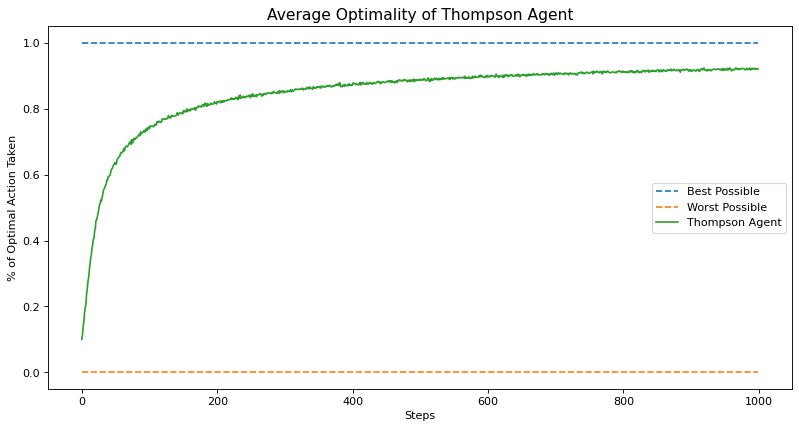

In [135]:
# Write your code for plotting the optimality ratio vs episodes
%matplotlib inline
%matplotlib inline
num_experiments = 10000
num_steps = 1000
num_actions = 10

# Initialize the environment
env = ArmedBanditsGaussian(num_experiments, num_actions)
# Initialize the agent
agent = ThompsonAgent(np.zeros((num_experiments,num_actions)),0,1)

# Store the scores and averages for later plotting
averages = np.zeros((num_steps))
optimality = np.zeros((num_steps))
scores = np.zeros((num_experiments, num_steps+1))

#Store the optimal actions for later use
optimal = np.argmax(env.mean, axis=1)

for i in tqdm(range(num_steps)):
    # Select an action to execute on the environment
    action = agent.get_action()
    _, reward, _, _ = env.step(action)
    
    # Update the agent estimates with the previously observed rewards
    agent.update_estimates(reward, action)
    # agent.plot(i)
    
    # Store the average cumulative score and optimality of the current step
    scores[:,i+1] = scores[:,i] + reward
    avg_score = np.mean(scores[:,i+1]/(i+1))
    averages[i] = avg_score
    
    # Get optimal actions from the environment
    current_optimality = np.mean(action == optimal)
    optimality[i] = current_optimality
    
plt.figure(figsize=(12,6), dpi=80, facecolor='w', edgecolor='k')
plt.plot([1.0 for _ in range(num_steps)], linestyle='--')
plt.plot([0.0 for _ in range(num_steps)], linestyle='--')
plt.plot(optimality)
plt.legend(["Best Possible", "Worst Possible", "Thompson Agent"])
plt.title("Average Optimality of Thompson Agent", fontsize=14)
plt.ylabel("% of Optimal Action Taken")
plt.xlabel("Steps")
plt.show()
thompson_agent_greedy_scores = averages
thompson_agent_greedy_optimality = optimality

## Part 5: Regret Plots and Comparison

In the lecture we defined `Regret` as $R(T) = \sum_{t=1}^T [\mu^* - \mu(a_t)]$. It represents how much the algorithm 'regrets' not knowing the best arm in advance. 

### 5.1 Regret Plots

Till now we have explored multiple learning strategies to solve the MAB problem. Write your code below to plot the average regret over 10000 experiments for the best cases (the case that reaches the highest optiimality action ratio) of all the above algorithms (discussed in Part 1-4 also include greedy and epsilon-greedy methods). Simulate the experiments for 1000 steps for a 10 arm MAB setting.     `[5 Marks]`

In [136]:
# Write your code for the experiment here
def regret_plot(agent, env, num_experiments, num_steps, num_actions,name):
    regret = np.zeros((num_experiments, num_steps))
    optimal = np.argmax(env.mean,axis=1)
    optimality = np.zeros((num_steps))
    for i in tqdm(range(num_steps)):
        # Select an action to execute on the environment
        if(name=="Time Varying Epsilon Greedy"):
            action = agent.get_action(i,num_steps)
        else:
            action = agent.get_action()
        _, reward, _, _ = env.step(action)
        # Update the agent estimates with the previously observed rewards
        agent.update_estimates(reward, action)
        regret[:,i] = env.mean[np.arange(num_experiments),action]

    Regret = env.mean[np.arange(num_experiments),optimal].reshape((num_experiments,1)) - regret #calculating regret for all experiments
    Regret = np.mean(Regret,axis=0) #averaging regret over number of time steps
    for i in range(1,num_steps):
        Regret[i] += Regret[i-1] #cumulative regret at time 't'
    
    plt.figure(figsize=(12,6), dpi=80, facecolor='w', edgecolor='k')
    plt.plot(Regret)
    plt.ylabel("Regret")
    plt.xlabel("Steps")
    plt.title(f"Regret Analysis for {name} Agent")
    plt.show()

100%|██████████| 1000/1000 [00:05<00:00, 170.44it/s]


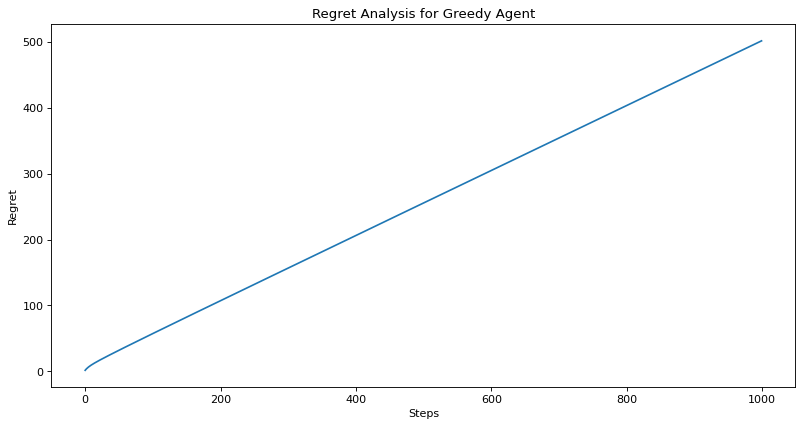

100%|██████████| 1000/1000 [00:05<00:00, 187.15it/s]


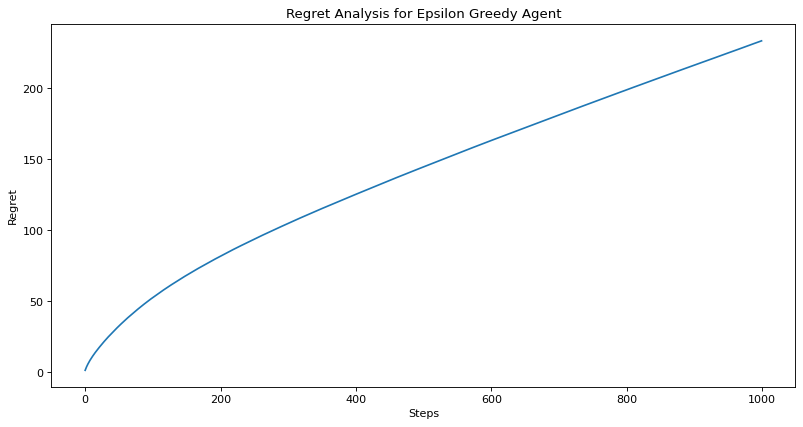

100%|██████████| 1000/1000 [00:05<00:00, 170.41it/s]


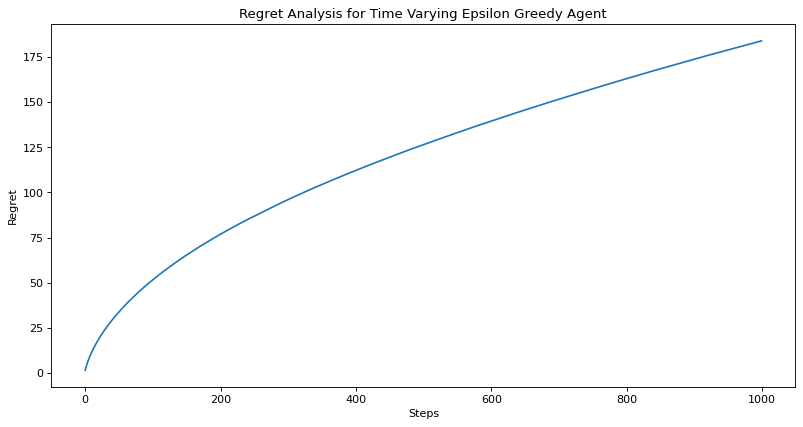

100%|██████████| 1000/1000 [00:49<00:00, 20.24it/s]


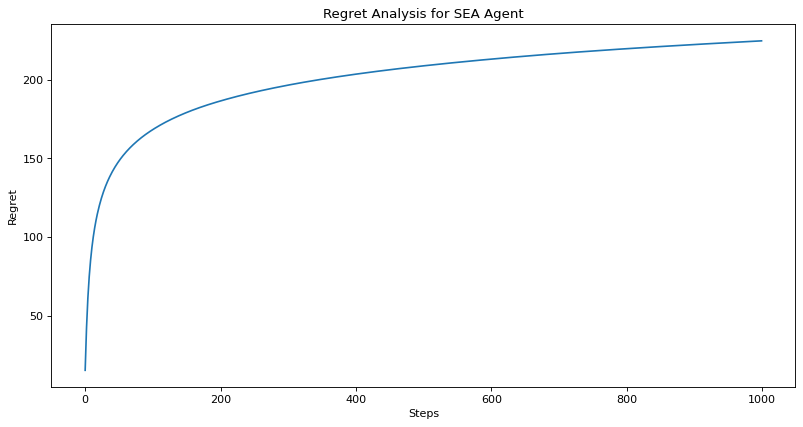

100%|██████████| 1000/1000 [00:06<00:00, 164.35it/s]


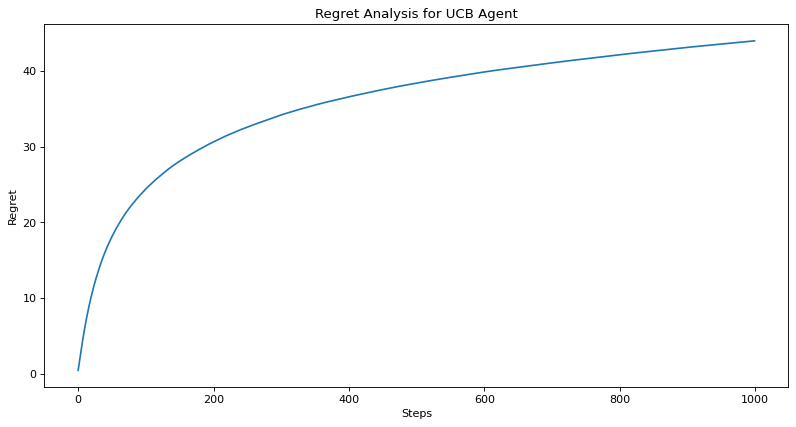

100%|██████████| 1000/1000 [00:11<00:00, 89.74it/s]


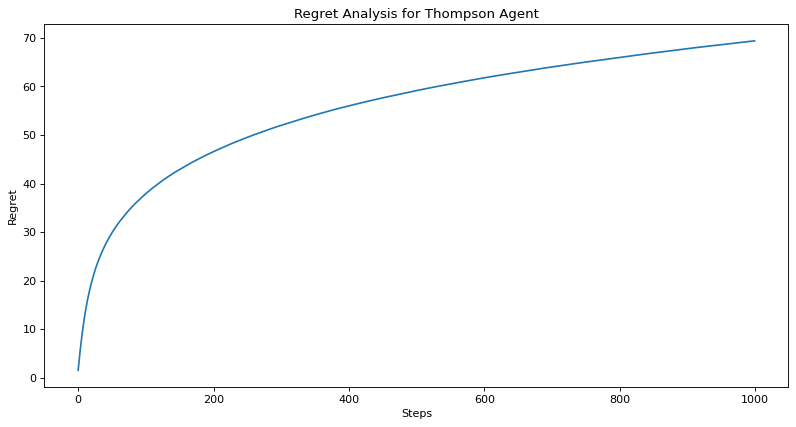

In [137]:
num_experiments = 10000
num_steps = 1000
num_actions = 10
env = ArmedBanditsGaussian(num_experiments, num_actions)
# Initialize the agent
agent = GreedyAgent(np.zeros((num_experiments, num_actions)))
regret_plot(agent,env, num_experiments, num_steps, num_actions,"Greedy")

agent = EpsilonGreedyAgent(np.zeros((num_experiments, num_actions)),0.1)
regret_plot(agent,env, num_experiments, num_steps, num_actions,"Epsilon Greedy")

agent = TimeVaryingGreedyAgent(np.zeros((num_experiments, num_actions)),0.5,"exponential")
regret_plot(agent,env, num_experiments, num_steps, num_actions,"Time Varying Epsilon Greedy")

#SEA
active_arms = np.full((num_experiments,num_actions),True,dtype =bool)
agent = SEA(np.zeros((num_experiments,num_actions)),active_arms,1)
regret = np.zeros((1, num_steps))
optimal = np.argmax(env.mean,axis=1)

for i in tqdm(range(num_steps)):
    # Select an action to execute on the environment
    action = agent.get_action()
    _, reward, _, _ = env.step(action)
    agent.update_estimates(reward,num_steps)
    regret[:,i] = regret[:,i-1] + (np.sum(env.mean[np.arange(num_experiments), optimal]*action.sum(axis = 1)) - np.sum(env.mean[action]))/num_experiments 
    #we are choosing active actions in every experiment, hence calculating regret as optimal mean*number of active actions  -  means of active actions and then calculating
    #the average across number of experiments

Regret = np.reshape(regret, (num_steps,))
plt.figure(figsize=(12,6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(Regret)
plt.ylabel("Regret")
plt.xlabel("Steps")
plt.title("Regret Analysis for SEA Agent")
plt.show()

#UCB
agent = ucbagent(np.zeros((num_experiments, num_actions)),1)
regret = np.zeros((num_experiments, num_steps))
optimal = np.argmax(env.mean,axis=1)
optimality = np.zeros((num_steps))
for i in range(num_actions):
    action = agent.do_all_actions(i)
    _, reward, _, _ = env.step(action)
    agent.update_estimates(reward, action)

for i in tqdm(range(num_steps)):
    # Select an action to execute on the environment
    action = agent.get_action(num_steps)
    _, reward, _, _ = env.step(action)
    agent.update_estimates(reward, action)
    regret[:,i] = env.mean[np.arange(num_experiments),action]

Regret = env.mean[np.arange(num_experiments),optimal].reshape((num_experiments,1)) - regret 
Regret = np.mean(Regret,axis=0)
for i in range(1,num_steps):
    Regret[i] += Regret[i-1]
plt.figure(figsize=(12,6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(Regret)
plt.ylabel("Regret")
plt.xlabel("Steps")
plt.title("Regret Analysis for UCB Agent")
plt.show()
        
agent = ThompsonAgent(np.zeros((num_experiments, num_actions)),0,1)
regret_plot(agent,env, num_experiments, num_steps, num_actions,"Thompson")

### 5.2 Based on the analysis and plots generated, answer the following questions and describe in detail

**5.2.1** What do you observe? How do regrets evolve for different methods? `[3 Marks]`

**5.2.2** Which agent/algorithm performs the best for the given setting? `[2 Marks]`

5.2.1 We observe that as the methods change the regrets evolve, the plot shows that for more number of time steps the regret is increasing but the increase becomes slower and less as the algorithms become better. This means that the accumulated regret becomes less for better algorithms hinting that algorithms like UCB, Thompson Sampling are able to choose the optimal actions most of the time. Compared to Greedy and Epsilon Greedy Methods, UCB Agent and Thompson Agent perform way better thus giving less regret for the whole episode.

5.2.2 UCB Agent performs the best for the given setting

### 5.3 Lower Bounds on regret

Repeat the above part 5.1 for a two bandit setting but instead of generating the true means for the bandit experiments using the gaussian distribution as used in the ArmedBanditsGaussian, use the true means specified below. 

**Case 1**: $\mu_1 = 1/60, \mu_2 = 0$ <br />
**Case 2**: $\mu_1 = 2/60, \mu_2 = 1/60$

Along with the regret for the algorithms also plot the regret lower bound for the two cases, the bound is given by the theorem below. `[5 Marks]`

`Theorem:` For any policy $\pi, \exists \mu = (\mu_1,\cdots,\mu_k) \in [0,1]^k$, with $P_{\nu_\mu} = (P_1,\cdots,P_k), P_j \sim \mathcal{N}(\mu_j,1)$ such that $R_t(\pi,\nu_\mu) \geq \frac{1}{27}\sqrt{(k-1)t}$ 

In [138]:
# Write your code for the experiment here
def regret_plot_lower_bound(agent, env, num_experiments, num_steps, num_actions,name):
    regret = np.zeros((num_experiments, num_steps))
    optimal = np.argmax(env.mean,axis=1)
    optimality = np.zeros((num_steps))
    for i in tqdm(range(num_steps)):
        # Select an action to execute on the environment
        if(name=="Time Varying Epsilon Greedy"):
            action = agent.get_action(i,num_steps)
        else:
            action = agent.get_action()
        _, reward, _, _ = env.step(action)
        # Update the agent estimates with the previously observed rewards
        agent.update_estimates(reward, action)
        regret[:,i] = env.mean[np.arange(num_experiments),action]
    Regret = env.mean[np.arange(num_experiments),optimal].reshape((num_experiments,1)) - regret 
    Regret = np.mean(Regret,axis=0)
    for i in range(1,num_steps):
        Regret[i] += Regret[i-1]
    
    plt.figure(figsize=(12,6), dpi=80, facecolor='w', edgecolor='k')
    plt.plot(Regret)
    plt.plot([1/27*np.sqrt(n) for n in range(num_steps)]) #the lower bound of regret
    plt.title(f"Regret Analysis for {name} Agent")
    plt.ylabel("Regret")
    plt.xlabel("Steps")
    plt.legend(["Empirical Regret","Lower Bound"])
    plt.show()

100%|██████████| 1000/1000 [00:02<00:00, 350.27it/s]


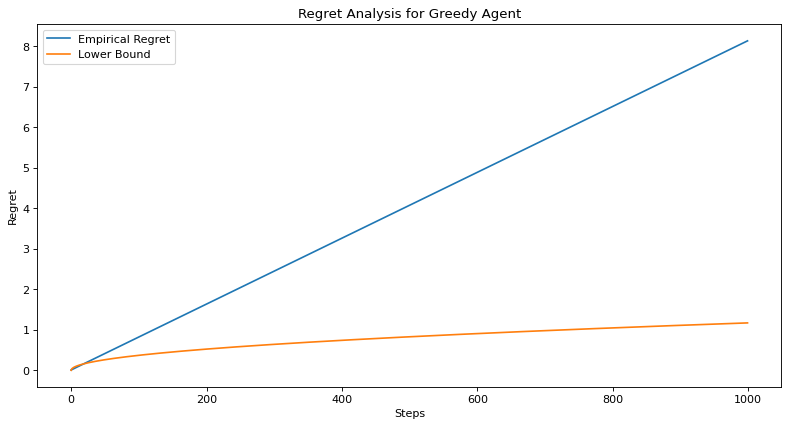

100%|██████████| 1000/1000 [00:03<00:00, 323.35it/s]


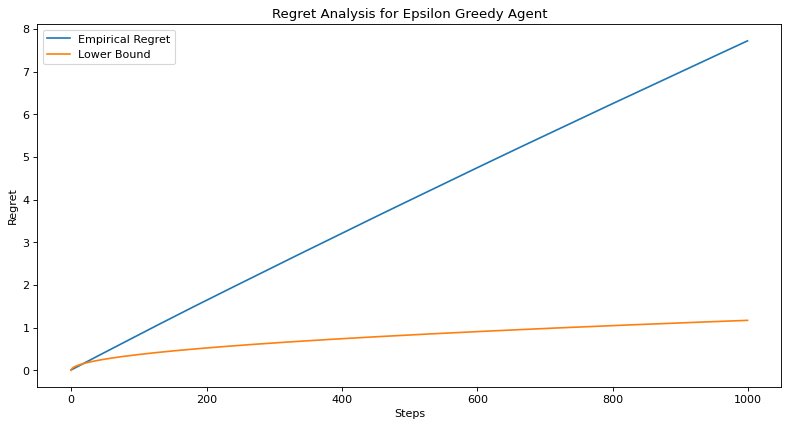

100%|██████████| 1000/1000 [00:04<00:00, 246.11it/s]


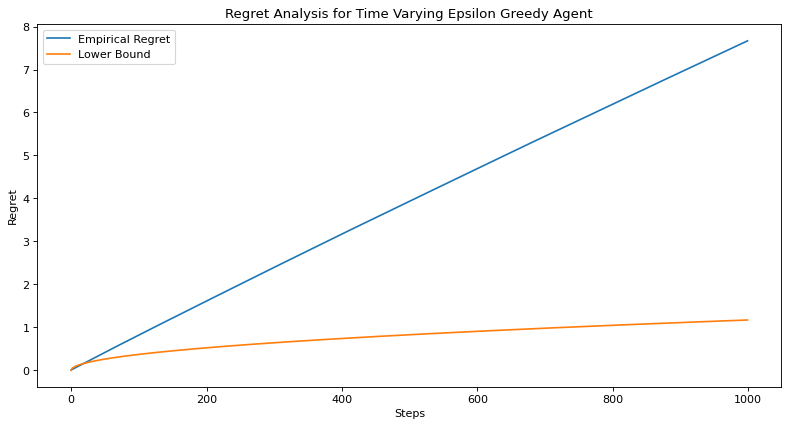

100%|██████████| 1000/1000 [00:53<00:00, 18.73it/s]


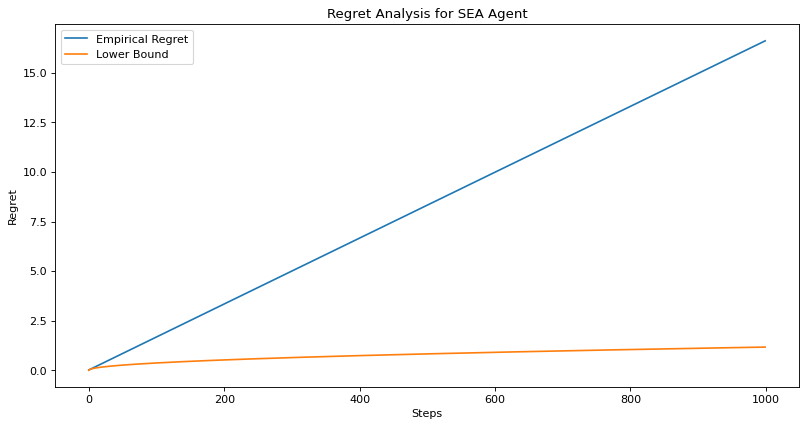

100%|██████████| 1000/1000 [00:03<00:00, 332.32it/s]


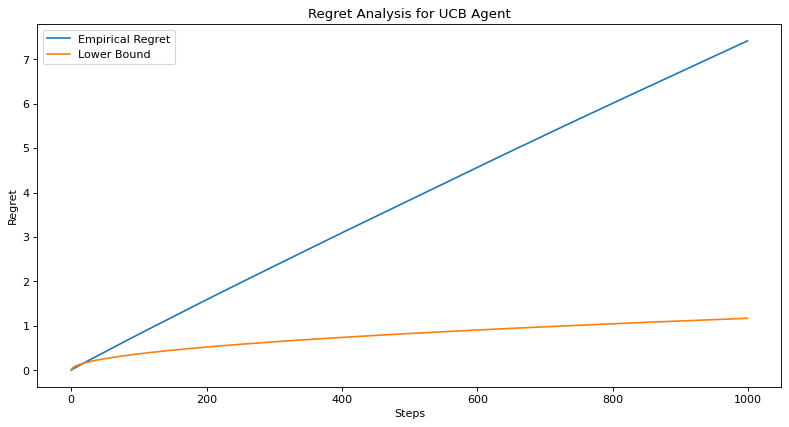

100%|██████████| 1000/1000 [00:03<00:00, 251.45it/s]


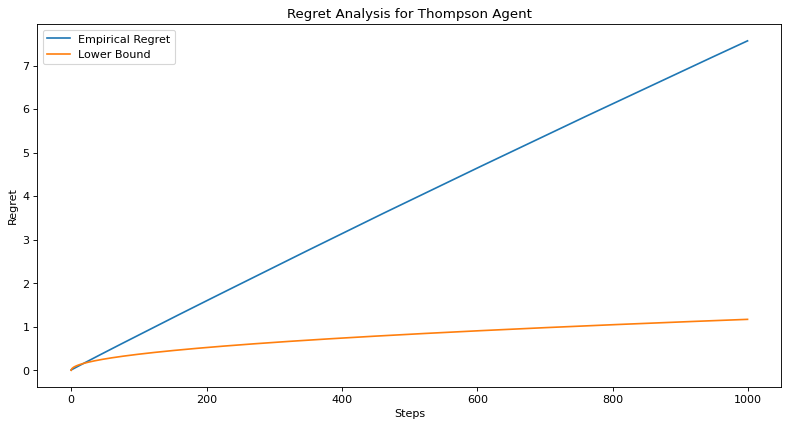

In [139]:
# write your code for this part here
#CASE 1
num_experiments = 10000
num_steps = 1000
num_actions = 2
a = np.array([1/60,0])
means = np.tile(a,(num_experiments,1))
env = ArmedBanditsEnv(means,np.ones((num_experiments, num_actions)))
# Initialize the agent
agent = GreedyAgent(np.zeros((num_experiments, num_actions)))
regret_plot_lower_bound(agent,env, num_experiments, num_steps, num_actions,"Greedy")
agent = EpsilonGreedyAgent(np.zeros((num_experiments, num_actions)),0.1)
regret_plot_lower_bound(agent,env, num_experiments, num_steps, num_actions,"Epsilon Greedy")
agent = TimeVaryingGreedyAgent(np.zeros((num_experiments, num_actions)),0.5,"exponential")
regret_plot_lower_bound(agent,env, num_experiments, num_steps, num_actions,"Time Varying Epsilon Greedy")

#SEA
active_arms = np.full((num_experiments,num_actions),True,dtype =bool)
agent = SEA(np.zeros((num_experiments,num_actions)),active_arms,1)
regret = np.zeros((1, num_steps))
optimal = np.argmax(env.mean,axis=1)

for i in tqdm(range(num_steps)):
    # Select an action to execute on the environment
    action = agent.get_action()
    _, reward, _, _ = env.step(action)
    agent.update_estimates(reward,num_steps)
    regret[:,i] = regret[:,i-1] + (np.sum(env.mean[np.arange(num_experiments), optimal]*action.sum(axis = 1)) - np.sum(env.mean[action]))/num_experiments

Regret = np.reshape(regret, (num_steps,))
plt.figure(figsize=(12,6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(Regret)
plt.plot([1/27*np.sqrt(n) for n in range(num_steps)])
plt.ylabel("Regret")
plt.xlabel("Steps")
plt.title("Regret Analysis for SEA Agent")
plt.legend(["Empirical Regret","Lower Bound"])
plt.show()

#UCB


agent = ucbagent(np.zeros((num_experiments, num_actions)),1)
regret = np.zeros((num_experiments, num_steps))
optimal = np.argmax(env.mean,axis=1)
optimality = np.zeros((num_steps))
for i in range(num_actions):
    action = agent.do_all_actions(i)
    _, reward, _, _ = env.step(action)
    agent.update_estimates(reward, action)

for i in tqdm(range(num_steps)):
    # Select an action to execute on the environment
    action = agent.get_action(num_steps)
    _, reward, _, _ = env.step(action)
    agent.update_estimates(reward, action)
    regret[:,i] = env.mean[np.arange(num_experiments),action]

Regret = env.mean[np.arange(num_experiments),optimal].reshape((num_experiments,1)) - regret 
Regret = np.mean(Regret,axis=0)
for i in range(1,num_steps):
    Regret[i] += Regret[i-1]

plt.figure(figsize=(12,6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(Regret)
plt.plot([1/27*np.sqrt(n) for n in range(num_steps)])
plt.title("Regret Analysis for UCB Agent")
plt.ylabel("Regret")
plt.xlabel("Steps")
plt.legend(["Empirical Regret","Lower Bound"])
plt.show()
        
agent = ThompsonAgent(np.zeros((num_experiments, num_actions)),0,1)
regret_plot_lower_bound(agent,env, num_experiments, num_steps, num_actions,"Thompson")

100%|██████████| 1000/1000 [00:03<00:00, 297.07it/s]


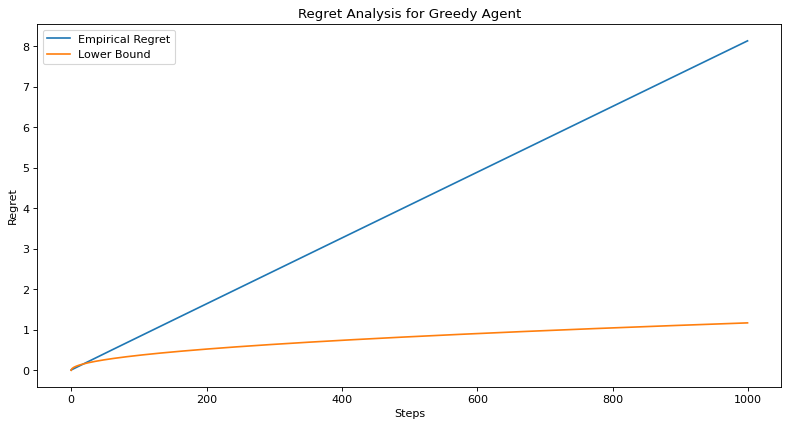

100%|██████████| 1000/1000 [00:03<00:00, 300.69it/s]


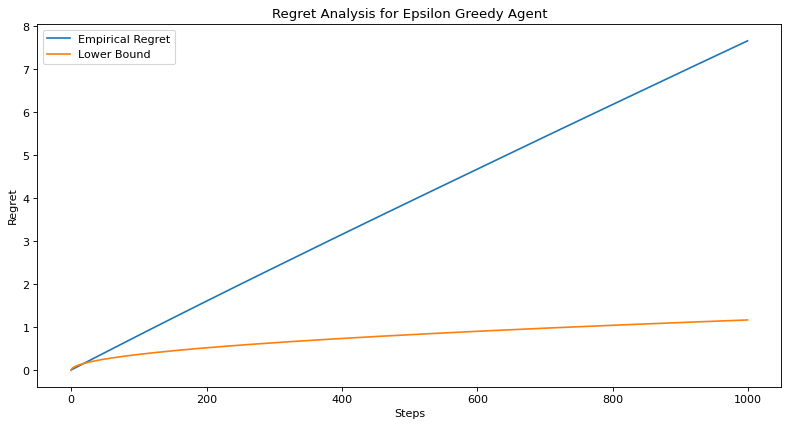

100%|██████████| 1000/1000 [00:03<00:00, 331.97it/s]


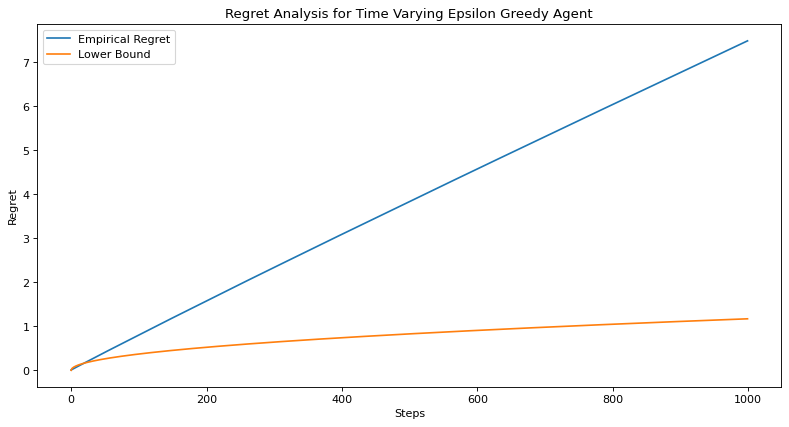

100%|██████████| 1000/1000 [00:50<00:00, 19.97it/s]


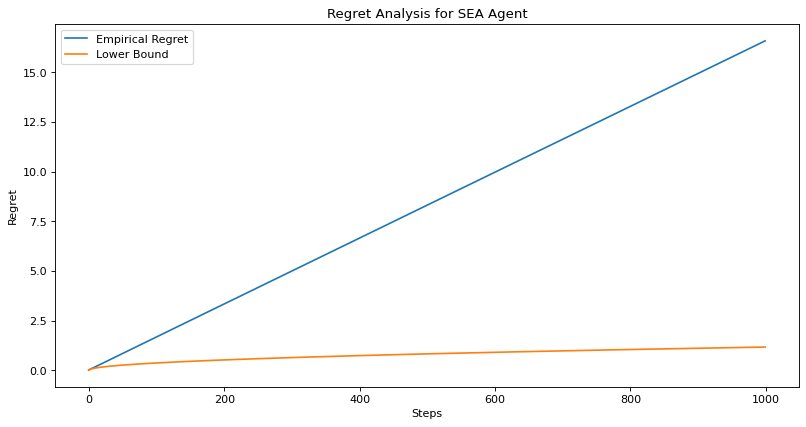

100%|██████████| 1000/1000 [00:02<00:00, 342.04it/s]


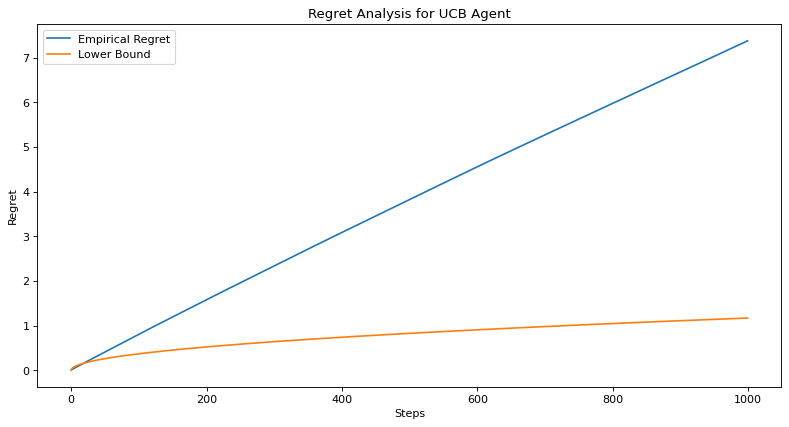

100%|██████████| 1000/1000 [00:06<00:00, 164.41it/s]


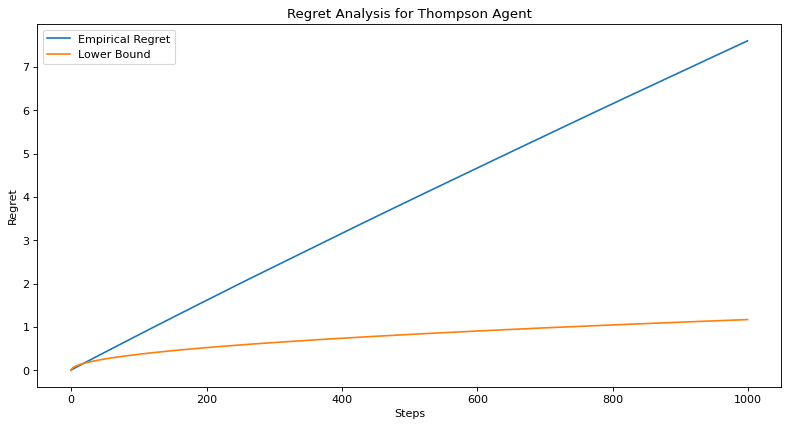

In [140]:
# write your code for this part here
#CASE 2
num_experiments = 10000
num_steps = 1000
num_actions = 2
a = np.array([2/60,1/60])
means = np.tile(a,(num_experiments,1))
env = ArmedBanditsEnv(means,np.ones((num_experiments, num_actions)))
# Initialize the agent
agent = GreedyAgent(np.zeros((num_experiments, num_actions)))
regret_plot_lower_bound(agent,env, num_experiments, num_steps, num_actions,"Greedy")
agent = EpsilonGreedyAgent(np.zeros((num_experiments, num_actions)),0.1)
regret_plot_lower_bound(agent,env, num_experiments, num_steps, num_actions,"Epsilon Greedy")
agent = TimeVaryingGreedyAgent(np.zeros((num_experiments, num_actions)),0.5,"exponential")
regret_plot_lower_bound(agent,env, num_experiments, num_steps, num_actions,"Time Varying Epsilon Greedy")

#SEA
active_arms = np.full((num_experiments,num_actions),True,dtype =bool)
agent = SEA(np.zeros((num_experiments,num_actions)),active_arms,1)
regret = np.zeros((1, num_steps))
optimal = np.argmax(env.mean,axis=1)

for i in tqdm(range(num_steps)):
    # Select an action to execute on the environment
    action = agent.get_action()
    _, reward, _, _ = env.step(action)
    agent.update_estimates(reward,num_steps)
    regret[:,i] = regret[:,i-1] + (np.sum(env.mean[np.arange(num_experiments), optimal]*action.sum(axis = 1)) - np.sum(env.mean[action]))/num_experiments

Regret = np.reshape(regret, (num_steps,))
plt.figure(figsize=(12,6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(Regret)
plt.plot([1/27*np.sqrt(n) for n in range(num_steps)])
plt.ylabel("Regret")
plt.xlabel("Steps")
plt.title("Regret Analysis for SEA Agent")
plt.legend(["Empirical Regret","Lower Bound"])
plt.show()

#UCB Agent
agent = ucbagent(np.zeros((num_experiments, num_actions)),1)
regret = np.zeros((num_experiments, num_steps))
optimal = np.argmax(env.mean,axis=1)
optimality = np.zeros((num_steps))
for i in range(num_actions):
    action = agent.do_all_actions(i)
    _, reward, _, _ = env.step(action)
    agent.update_estimates(reward, action)

for i in tqdm(range(num_steps)):
    # Select an action to execute on the environment
    action = agent.get_action(num_steps)
    _, reward, _, _ = env.step(action)
    agent.update_estimates(reward, action)
    regret[:,i] = env.mean[np.arange(num_experiments),action]

Regret = env.mean[np.arange(num_experiments),optimal].reshape((num_experiments,1)) - regret 
Regret = np.mean(Regret,axis=0)
for i in range(1,num_steps):
    Regret[i] += Regret[i-1]

plt.figure(figsize=(12,6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(Regret)
plt.plot([1/27*np.sqrt(n) for n in range(num_steps)])
plt.title("Regret Analysis for UCB Agent")
plt.ylabel("Regret")
plt.xlabel("Steps")
plt.legend(["Empirical Regret","Lower Bound"])
plt.show()
        
agent = ThompsonAgent(np.zeros((num_experiments, num_actions)),0,1)
regret_plot_lower_bound(agent,env, num_experiments, num_steps, num_actions,"Thompson")

**5.3.1** How does the lower bound regret curve compare to the other algorithms regret?  
**5.3.2** In witch of the cases the emperical regret is strictly grater than the lower bound? 

5.3.1 Lower Bound Regret Curve is below compared to the other algortihms regret and is a good lower bound for the regrets of all the algorithms.

5.3.2 For SEA agent, the emperical regret is strictly greater than the lower bound.

## Part 6: Hoeffding Inequality

$\mathbb{P}(|\bar{\mu}-\mu|\geq \epsilon) \leq 2\exp{(-2\epsilon^2N)} $

Hoeffding's inequality provides an upper bound on the probability that the estimated mean of a bounded independent random variables deviates from its true value by more than a certain amount $\epsilon$. Hoeffding inquality is extremely widely used in machine learning theory. The intuition for this result is very simple. We have a bunch of random variables. We know that when we average them up, we should usually get something close to the expected value. Hoeffding simply quantifies “usually” and “close” for us.

### 6.1 Monte Carlo Simulations

For this part run monte carlo simulations to verify the inequality. Generate $N$ samples from a given distribution with known $\mu$. For given a $\epsilon$, plot the emperical probabilty of deviating from the mean by more than  $\epsilon$ vs $N$ averaged over multiple experiments along with the plot of upper bound of the Hoeffding inequality for the following cases in seperate figures:

1) Binomial Distribution with $p = 0.5, \epsilon = 0.25$ for $N\in [1,100]$
2) Binomial Distribution with $p = 0.5, \epsilon = 0.05$ for $N\in [1,1000]$
3) Binomial Distribution with $p = 0.1, \epsilon = 0.25$ for $N\in [1,100]$
4) Binomial Distribution with $p = 0.1, \epsilon = 0.05$ for $N\in [1,1000]$ 
5) Beta Distribution with $\alpha = 1, \beta = 1, \epsilon = 0.25$ for $N\in [1,100]$
6) Beta Distribution with $\alpha = 2, \beta = 5, \epsilon = 0.05$ for $N\in [1,1000]$

`[7.5 Marks]`

In [141]:
# write your code for this part here
def bernoulli(p,epsilon,N):
    samples = np.random.binomial(1,p,N)
    averages = np.zeros(samples.shape)
    averages[0] = samples[0]
    for i in range(1,N):
        averages[i] = inc_avg(averages[i-1],samples[i],i+1) #averages with respect to number of samples
    true_mean = p
    averages = np.abs(averages - true_mean) >= epsilon
    return averages

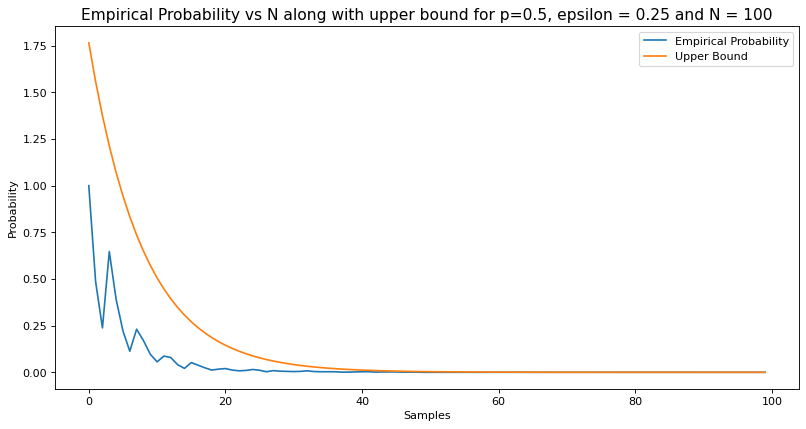

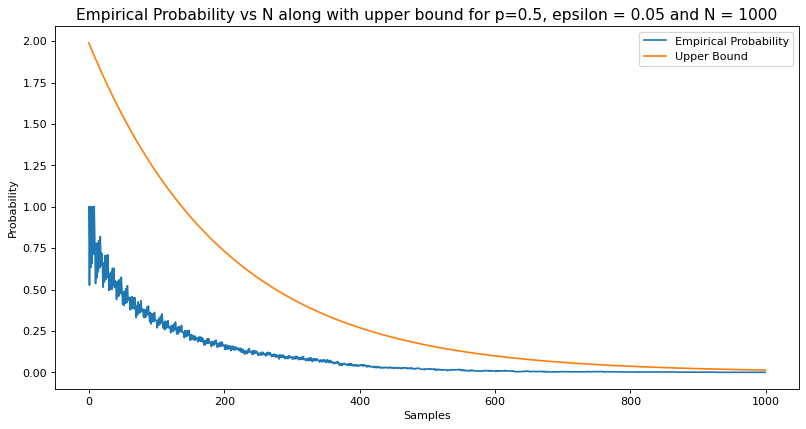

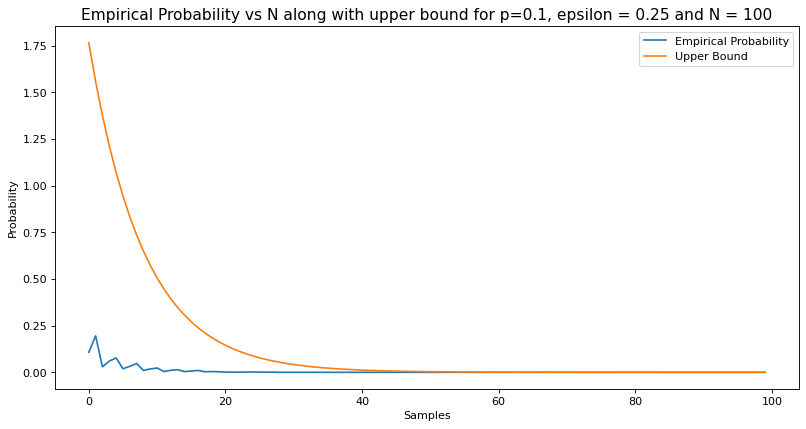

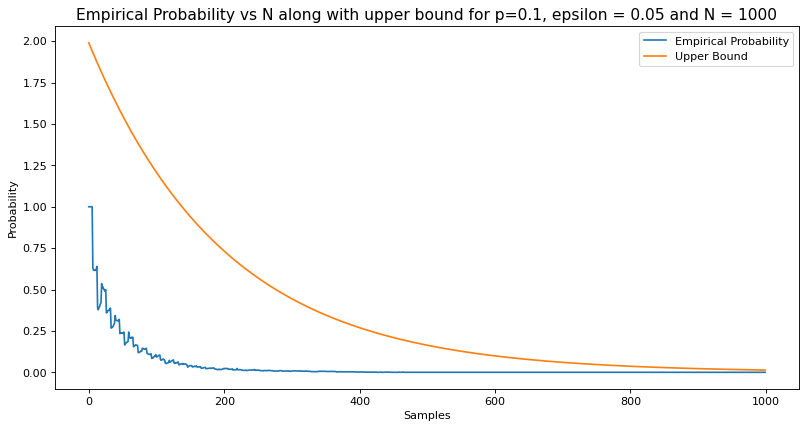

In [142]:
%matplotlib inline
num_experiments = 1000
p = [0.5,0.5,0.1,0.1]
epsilon = [0.25,0.05,0.25,0.05]
N = [100,1000,100,1000]
for i in range(4):
    emp_prob = np.zeros((N[i]))
    probabilities = np.zeros((num_experiments, N[i]))
    for j in range(num_experiments):
        probability = bernoulli(p[i],epsilon[i],N[i])
        probabilities[j,:] = probability
    emp_prob = np.mean(probabilities,axis=0) #will give the total probability for number of experiments across time samples
    plt.figure(figsize=(12,6), dpi=80, facecolor='w', edgecolor='k')
    plt.plot(emp_prob)
    plt.plot([2*np.exp(-2*epsilon[i]*epsilon[i]*n) for n in range(1,N[i]+1)])
    plt.legend(["Empirical Probability", "Upper Bound"])
    plt.title(f"Empirical Probability vs N along with upper bound for p={p[i]}, epsilon = {epsilon[i]} and N = {N[i]}", fontsize=14)
    plt.ylabel("Probability")
    plt.xlabel("Samples")
    plt.show()

In [143]:
def beta(alpha,b,epsilon,N):
    samples = np.random.beta(alpha,b,N)
    averages = np.zeros(samples.shape)
    probabilities = np.zeros(samples.shape)
    averages[0] = samples[0]
    for i in range(1,N):
        averages[i] = inc_avg(averages[i-1],samples[i],i+1)
    true_mean = alpha/(alpha+b)
    averages = np.abs(averages - true_mean) >= epsilon
    return averages

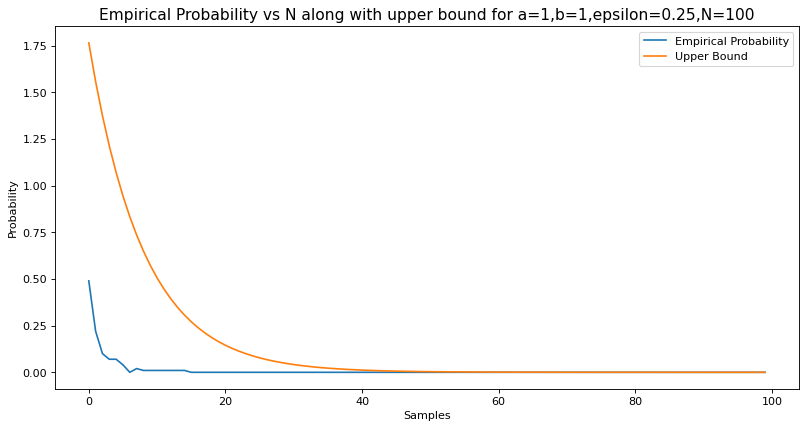

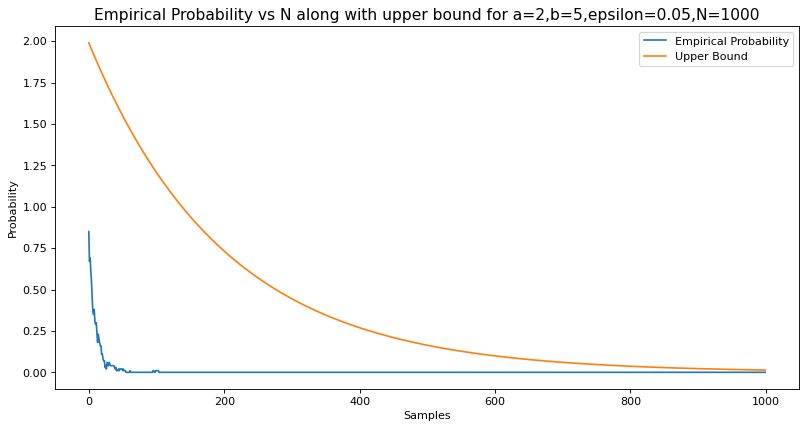

In [145]:
%matplotlib inline
num_experiments = 100
alpha = [1,2]
b = [1,5]
epsilon = [0.25,0.05]
N = [100,1000]
for i in range(2):
    emp_prob = np.zeros((N[i]))
    probabilities = np.zeros((num_experiments, N[i]))
    for j in range(num_experiments):
        probability = beta(alpha[i],b[i],epsilon[i],N[i])
        probabilities[j,:] = probability
    emp_prob = np.mean(probabilities,axis=0)
    plt.figure(figsize=(12,6), dpi=80, facecolor='w', edgecolor='k')
    plt.plot(emp_prob)
    plt.plot([2*np.exp(-2*epsilon[i]*epsilon[i]*n) for n in range(1,N[i]+1)])
    plt.legend(["Empirical Probability", "Upper Bound"])
    plt.title(f"Empirical Probability vs N along with upper bound for a={alpha[i]},b={b[i]},epsilon={epsilon[i]},N={N[i]}", fontsize=14)
    plt.ylabel("Probability")
    plt.xlabel("Samples")
    plt.show()

### 6.2 Based on the plots generated answer the following questions:
**6.2.1** For what value of $p=\{0.1,0.5\}$ for the Binomial distribution the upper bound is tighter than the other? <br />
**6.2.2** For the Binomial distribution with $p=0.9$ will Hoeffding inequality be loose or tight?

`[2.5 Marks]`

6.2.1 For p = 0.5 the bound is tighter, as seen from the graph the values are more close to the bound for p=0.5 compared to p=0.1 hence it's more tighter

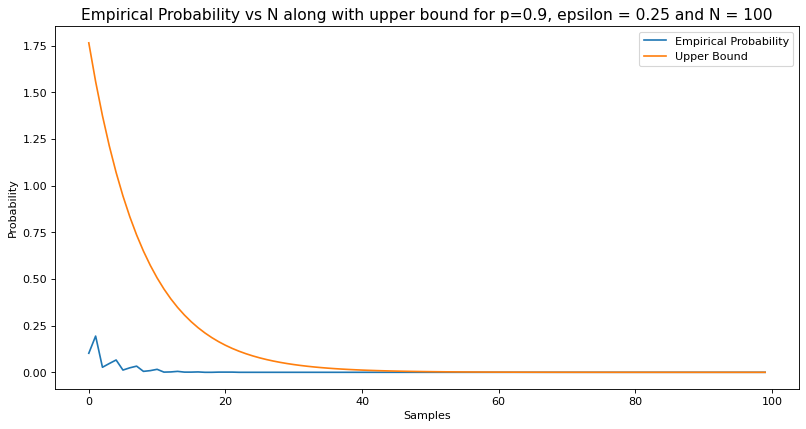

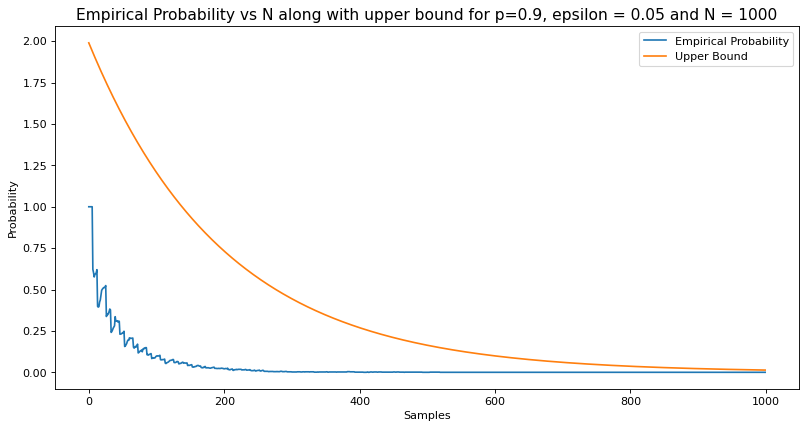

In [68]:
num_experiments = 1000
p = [0.9,0.9]
epsilon = [0.25,0.05]
N = [100,1000]
for i in range(2):
    emp_prob = np.zeros((N[i]))
    probabilities = np.zeros((num_experiments, N[i]))
    for j in range(num_experiments):
        probability = bernoulli(p[i],epsilon[i],N[i])
        probabilities[j,:] = probability
    emp_prob = np.mean(probabilities,axis=0) #will give the total probability for number of experiments across time samples
    plt.figure(figsize=(12,6), dpi=80, facecolor='w', edgecolor='k')
    plt.plot(emp_prob)
    plt.plot([2*np.exp(-2*epsilon[i]*epsilon[i]*n) for n in range(1,N[i]+1)])
    plt.legend(["Empirical Probability", "Upper Bound"])
    plt.title(f"Empirical Probability vs N along with upper bound for p={p[i]}, epsilon = {epsilon[i]} and N = {N[i]}", fontsize=14)
    plt.ylabel("Probability")
    plt.xlabel("Samples")
    plt.show()

6.2.2 For p=0.9, the hoeffding inequality bound will be loose. It is almost similar to p=0.1 as can be inferred from the graphs above

# Part 7: Failure of Greedy Algorithm

### 7.1 Bernoulli Bandits
Create an ArmBanditBernoulli class, that simulates MAB problem for the bernaulli bandit similar to ArmBanditEnv class. Using the calss simulate the following part. `[2 Marks]`

In [69]:
# write your code for this part here
class ArmBanditBernoulli():
    def __init__(self, mean):
        assert(len(mean.shape)) == 2

        self.num_bandits = mean.shape[1]
        self.num_experiments = mean.shape[0]
        
        self.mean = mean
    
    def step(self,action):
        # Sample from the specified bandit using it's reward distribution
        assert (action < self.num_bandits).all()

        sampled_means = self.mean[np.arange(self.num_experiments),action]
        reward = np.random.binomial(1,sampled_means,size = (1,self.num_experiments)) #bernoulli

        # Return a constant state of 0. Our environment has no terminal state
        observation, done, info = 0, False, dict()
        return observation, reward, done, info
  
    def reset(self):
        return 0
        
    def render(self, mode='human', close=False):
        pass
    
    def _seed(self, seed=None):
        self.np_random, seed = seeding.np.random(seed)
        return [seed]
    
    def close(self):
        pass

### 7.2 Two arm Bernoulli Bandit simulation
Consider a Bernoulli bandit with two arms and means $\mu_1 = 0.5$ and $\mu_2 = 0.6$

**7.2.1** Using a horizon of $T = 100$, run $1000$ simulations of your implementation of Greedy algorithm on the Bernoulli bandit above and record the (random) pseudo regret, $R(T) = \sum_{t=1}^T [\mu^* - \mu(a_t)]$, in each simulation. Plot the results uing a histogram and explain the results in the figure. `[3 Marks]`

100%|██████████| 100/100 [00:00<00:00, 2917.29it/s]


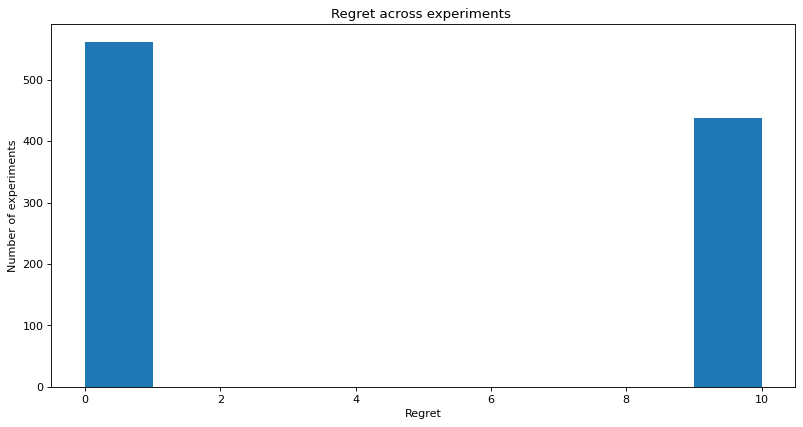

In [96]:
# write your code for this part here
%matplotlib inline
num_experiments = 1000
num_actions = 2
num_steps = 100
a = np.array([0.5,0.6])
means = np.tile(a,(num_experiments,1))

env_bernoulli = ArmBanditBernoulli(means)

agent = GreedyAgent(np.zeros((num_experiments, num_actions)))

regret = np.zeros((num_experiments, num_steps))
for i in tqdm(range(num_steps)):
    # Select an action to execute on the environment
    action = agent.get_action()
    _, reward, _, _ = env_bernoulli.step(action)
    regret[:,i] = a[action]
    # Update the agent estimates with the previously observed rewards
    agent.update_estimates(reward, action)

Regret = 0.6*num_steps - np.sum(regret,axis = 1)
plt.figure(figsize=(12,6), dpi=80, facecolor='w', edgecolor='k')
plt.hist(Regret)
plt.title("Regret across experiments ")
plt.xlabel("Regret")
plt.ylabel("Number of experiments")
plt.show()

In the Bernoulli Bandit problem, the problem with the greedy approach is that let's say if one of the arms is selected and the reward by using that arm is 1 then the greedy approach will always pick that arm only since now the arm which has been selected, its estimated mean will always be greater than 0, which is greater than the estimated mean of the other arm which is still 0. Hence, the regret will lie between 0 and 1 & 9 and 10, this means that when the first reward comes from the optimal arm, the regret will be 0 after that trial and if the first reward comes from the suboptimal arm then the regret will be 0.1 times the number of trials left. 

**7.2.2** Run 1000 simulations of your implementation of follow-the-leader for each horizon $T\in\{100, 200, 300, . . . , 1000\}$ . Plot the average regret obtained as a function of $T$. Because the average regret is an estimator of the expected regret, you should generally include error bars to indicate the uncertainty in the estimation. Explain the plot. Do you think follow-the-leader is a good algorithm? Why/why not? `[5 Marks]`

In [72]:
# write your code for this part here
%matplotlib inline
def run_bernoulli(num_experiments, num_actions, num_steps):
    a = np.array([0.5,0.6])
    means = np.tile(a,(num_experiments,1))

    env_bernoulli = ArmBanditBernoulli(means)

    agent = GreedyAgent(np.zeros((num_experiments, num_actions)))

    regret = np.zeros((num_experiments, num_steps))
    for i in tqdm(range(num_steps)):
        # Select an action to execute on the environment
        action = agent.get_action()
        _, reward, _, _ = env_bernoulli.step(action)
        regret[:,i] = a[action]
        # Update the agent estimates with the previously observed rewards
        agent.update_estimates(reward, action)
        
    Regret = (0.6*num_steps - np.sum(regret,axis = 1))/num_steps
    return Regret

100%|██████████| 1000/1000 [00:00<00:00, 1650.81it/s]


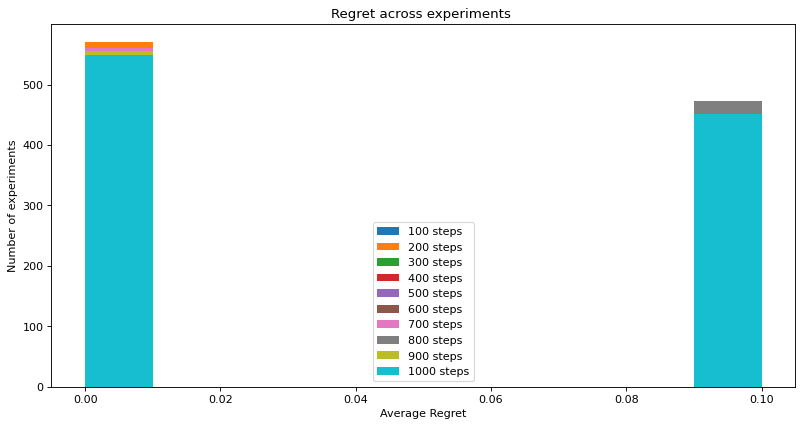

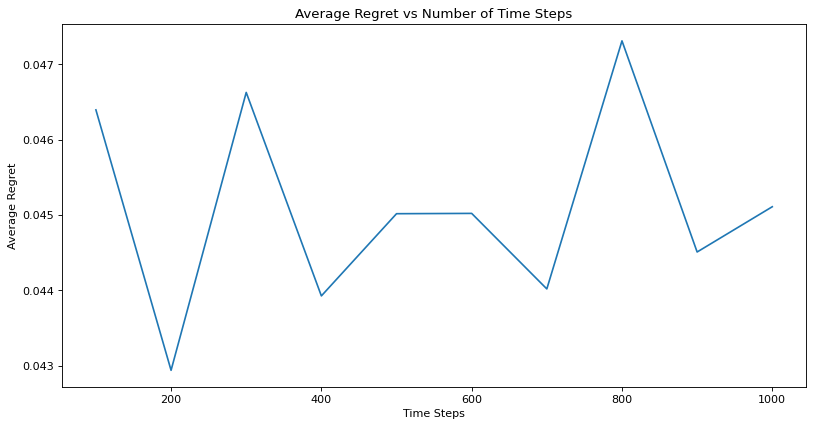

In [98]:
%matplotlib inline
num_experiments = 1000
num_actions = 2
T = np.array([100,200,300,400,500,600,700,800,900,1000])
Regret = np.zeros((10,num_experiments))
plt.figure(figsize=(12,6), dpi=80, facecolor='w', edgecolor='k')
for i in range(10):
    Regret[i] = run_bernoulli(num_experiments, num_actions, T[i])
    plt.hist(Regret[i],label=f'{T[i]} steps')
plt.legend()  
plt.title("Regret across experiments ")
plt.xlabel("Average Regret")
plt.ylabel("Number of experiments")
plt.show()

plt.figure(figsize=(12,6), dpi=80, facecolor='w', edgecolor='k')
Regret = np.mean(Regret,axis=1)
x_axis = np.array([100,200,300,400,500,600,700,800,900,1000])
plt.plot(x_axis,Regret)
plt.title("Average Regret vs Number of Time Steps")
plt.xlabel("Time Steps")
plt.ylabel("Average Regret")
plt.show()

Here, I have plotted two plots - the histogram which shows the average regret versus the number of experiments for each of the different T's. Seeing the histogram,it can be inferred that follow-the-leader is not an optimal algorithm as the regret is random across different number of steps. For whichever experiment, follow-the-leader algorithm got the first reward from the optimal arm, there the regret is small as now it always chooses the optimal arm but when it gets a reward first from the suboptimal arm in early time steps then regret could be large.

The same can be inferred from the line plot, where there is no relation between the average regret obtained versus the number of time steps, a lower regret means the reward from the optimal arm was found early and a higher regret means, the optimal arm was found later or not found.

Follow-the-leader is not a good algorithm because the algortihm may choose the sub-optimal arm and may stick with it for the rest of the time steps if the first reward comes from it without any chance of exploration to the optimal arm after getting the first reward.

***
**Name:** Rishabh Katiyar  <br />
**Roll No:** 190702